# IID Data - SGD & Adagrad

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Subset

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.models import vgg11

from sklearn.model_selection import KFold

import numpy as np
import matplotlib.pyplot as plt

from lib.models import model
from lib.server import Server
from lib.client import Client
from lib.data_helper import *
from lib.train_helper import *
from lib.plots import plot_loss_epoch

# Device

In [2]:
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

# SGD

# Manual Seeding

In [3]:
seed_generators()

# Data

In [4]:
train_dataset = CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
train_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_dataset = CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())
test_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

# Server & Clients

In [6]:
num_clients = 8
num_classes = 10

## Data repartition among clients

In [7]:
proportions = generate_proportions(num_clients,num_classes,alpha=10e8)
proportions

[tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250])]

# Cross Validation

In [8]:
def run_FedAvg(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optimizer,lr,**kwargs):
    
    train_loader = DeviceDataLoader(DataLoader(train_dataset, batch_size, shuffle=True), device)
    valid_loader = DeviceDataLoader(DataLoader(valid_dataset, batch_size, shuffle=True), device)
    history = []

    server.reset_weights()
    for i in range(rounds):
        print(f'>>> Round {i+1} ...')
        server_params = server.net.state_dict()
        clients_params = []
        for client in clients:
            client.train(device,server_params,epochs,batch_size, optimizer,lr,**kwargs)
        server.merge(clients)
        
        train_loss, train_acc = evaluate(server.net,train_loader)
        valid_loss, valid_acc = evaluate(server.net,valid_loader)
        
        print(f'''
Server :
    - training loss = {train_loss:.4f}
    - training accuracy = {train_acc:.4f}
    - validation loss = {valid_loss:.4f}
    - validation accuracy = {valid_acc:.4f}
        ''')
        
        history.append([train_loss, valid_loss, train_acc, valid_acc])
    return history

In [9]:
def run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr,**kwargs):
    folds = KFold(n_splits=n_splits,shuffle=True,random_state=42).split(np.arange(len(train_dataset)))

    results = []
    for fold, (train_idx,valid_idx) in enumerate(folds):
        print("="*25)
        print(f"Fold #{fold}")
        print("="*25)

        # create train and validation subsets
        train_subset = Subset(train_dataset, train_idx)
        valid_subset = Subset(train_dataset, valid_idx)

        # split data between users
        partition = partition_by_class(train_subset)
        clients = [Client(i,d,model().to(device)) for i,d in enumerate(split(partition,proportions),start=1)]
        server = Server(model().to(device))
        
        for c in clients:
            print(f"client {c.client_id} : {len(c.dataset)} samples")
        print()
        
        history = run_FedAvg(server,clients,device,train_subset,valid_subset,rounds,epochs,batch_size,optimizer,lr,**kwargs)
        
        plot_loss_epoch(history)
        
        results.append(history[-1][-1])
        
        
    return torch.tensor(results).mean()

Fold #0
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.2709, Accuracy = 0.5563
client 2 : Loss = 1.2369, Accuracy = 0.5674
client 3 : Loss = 1.4106, Accuracy = 0.5215
client 4 : Loss = 1.1884, Accuracy = 0.5727
client 5 : Loss = 1.3303, Accuracy = 0.5522
client 6 : Loss = 1.2044, Accuracy = 0.5773
client 7 : Loss = 1.2081, Accuracy = 0.5779
client 8 : Loss = 1.2723, Accuracy = 0.5617

Server :
    - training loss = 1.4568
    - training accuracy = 0.4694
    - validation loss = 1.5063
    - validation accuracy = 0.4490
        
>>> Round 2 ...
client 1 : Loss = 0.9759, Accuracy = 0.6520
client 2 : Loss = 0.9378, Accuracy = 0.6726
client 3 : Loss = 1.0515, Accuracy = 0.6313
client 4 : Loss = 0.9486, Accuracy = 0.6789
client 5 : Loss = 0.9004, Accuracy = 0.6798
client 6 : Loss = 1.0125, Accuracy = 0.6405
clie

client 6 : Loss = 0.0455, Accuracy = 0.9872
client 7 : Loss = 0.1401, Accuracy = 0.9544
client 8 : Loss = 0.2704, Accuracy = 0.9139

Server :
    - training loss = 0.1833
    - training accuracy = 0.9358
    - validation loss = 0.9862
    - validation accuracy = 0.7348
        
>>> Round 17 ...
client 1 : Loss = 0.1625, Accuracy = 0.9420
client 2 : Loss = 0.0413, Accuracy = 0.9889
client 3 : Loss = 0.2305, Accuracy = 0.9367
client 4 : Loss = 0.0923, Accuracy = 0.9699
client 5 : Loss = 0.0993, Accuracy = 0.9692
client 6 : Loss = 0.0368, Accuracy = 0.9924
client 7 : Loss = 0.0896, Accuracy = 0.9752
client 8 : Loss = 0.0757, Accuracy = 0.9805

Server :
    - training loss = 0.1412
    - training accuracy = 0.9527
    - validation loss = 0.9464
    - validation accuracy = 0.7464
        
>>> Round 18 ...
client 1 : Loss = 0.2019, Accuracy = 0.9457
client 2 : Loss = 0.0621, Accuracy = 0.9815
client 3 : Loss = 0.2040, Accuracy = 0.9324
client 4 : Loss = 0.1024, Accuracy = 0.9715
client 5 : L

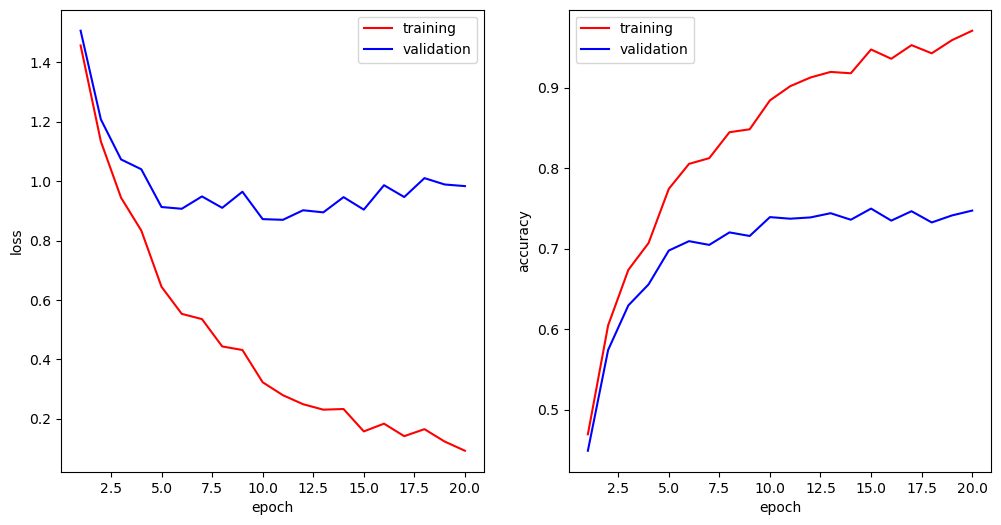

Fold #1
client 1 : 5002 samples
client 2 : 4996 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4996 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.2377, Accuracy = 0.5685
client 2 : Loss = 1.5068, Accuracy = 0.4854
client 3 : Loss = 1.2277, Accuracy = 0.5688
client 4 : Loss = 1.2738, Accuracy = 0.5547
client 5 : Loss = 1.3314, Accuracy = 0.5394
client 6 : Loss = 1.2018, Accuracy = 0.5827
client 7 : Loss = 1.4162, Accuracy = 0.5172
client 8 : Loss = 1.2510, Accuracy = 0.5564

Server :
    - training loss = 1.6019
    - training accuracy = 0.4308
    - validation loss = 1.6431
    - validation accuracy = 0.4195
        
>>> Round 2 ...
client 1 : Loss = 0.8955, Accuracy = 0.6746
client 2 : Loss = 1.1501, Accuracy = 0.5900
client 3 : Loss = 0.8244, Accuracy = 0.7086
client 4 : Loss = 0.9894, Accuracy = 0.6549
client 5 : Loss = 1.0047, Accuracy = 0.6423
client 6 : Loss = 0.8949, Accuracy = 0.6842
clie

client 6 : Loss = 0.0823, Accuracy = 0.9807
client 7 : Loss = 0.0726, Accuracy = 0.9830
client 8 : Loss = 0.0674, Accuracy = 0.9834

Server :
    - training loss = 0.1669
    - training accuracy = 0.9432
    - validation loss = 0.9432
    - validation accuracy = 0.7399
        
>>> Round 17 ...
client 1 : Loss = 0.0365, Accuracy = 0.9934
client 2 : Loss = 0.4965, Accuracy = 0.8525
client 3 : Loss = 0.1859, Accuracy = 0.9349
client 4 : Loss = 0.1150, Accuracy = 0.9691
client 5 : Loss = 0.0487, Accuracy = 0.9870
client 6 : Loss = 0.0827, Accuracy = 0.9773
client 7 : Loss = 0.3685, Accuracy = 0.8861
client 8 : Loss = 0.0520, Accuracy = 0.9868

Server :
    - training loss = 0.2003
    - training accuracy = 0.9293
    - validation loss = 1.0346
    - validation accuracy = 0.7217
        
>>> Round 18 ...
client 1 : Loss = 0.1105, Accuracy = 0.9616
client 2 : Loss = 0.1918, Accuracy = 0.9393
client 3 : Loss = 0.0338, Accuracy = 0.9941
client 4 : Loss = 0.2726, Accuracy = 0.9113
client 5 : L

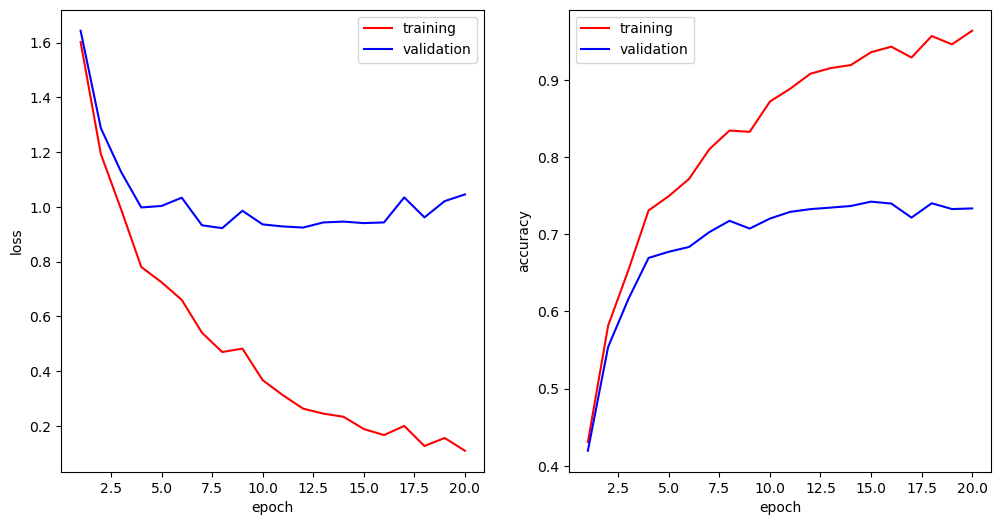

Fold #2
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.1228, Accuracy = 0.6045
client 2 : Loss = 1.2204, Accuracy = 0.5732
client 3 : Loss = 1.2306, Accuracy = 0.5613
client 4 : Loss = 1.2329, Accuracy = 0.5789
client 5 : Loss = 1.2968, Accuracy = 0.5511
client 6 : Loss = 1.1479, Accuracy = 0.6018
client 7 : Loss = 1.2183, Accuracy = 0.5715
client 8 : Loss = 1.2622, Accuracy = 0.5600

Server :
    - training loss = 1.4584
    - training accuracy = 0.4703
    - validation loss = 1.5035
    - validation accuracy = 0.4507
        
>>> Round 2 ...
client 1 : Loss = 0.9115, Accuracy = 0.6814
client 2 : Loss = 1.0269, Accuracy = 0.6458
client 3 : Loss = 0.8349, Accuracy = 0.6990
client 4 : Loss = 0.7953, Accuracy = 0.7098
client 5 : Loss = 0.9732, Accuracy = 0.6569
client 6 : Loss = 0.9067, Accuracy = 0.6812
clie

client 6 : Loss = 0.1005, Accuracy = 0.9717
client 7 : Loss = 0.1285, Accuracy = 0.9603
client 8 : Loss = 0.1316, Accuracy = 0.9574

Server :
    - training loss = 0.1846
    - training accuracy = 0.9361
    - validation loss = 1.0386
    - validation accuracy = 0.7317
        
>>> Round 17 ...
client 1 : Loss = 0.2189, Accuracy = 0.9250
client 2 : Loss = 0.0987, Accuracy = 0.9715
client 3 : Loss = 0.2129, Accuracy = 0.9322
client 4 : Loss = 0.1120, Accuracy = 0.9671
client 5 : Loss = 0.0599, Accuracy = 0.9820
client 6 : Loss = 0.1528, Accuracy = 0.9584
client 7 : Loss = 0.0377, Accuracy = 0.9941
client 8 : Loss = 0.0673, Accuracy = 0.9822

Server :
    - training loss = 0.1314
    - training accuracy = 0.9554
    - validation loss = 1.0302
    - validation accuracy = 0.7365
        
>>> Round 18 ...
client 1 : Loss = 0.1932, Accuracy = 0.9375
client 2 : Loss = 0.1382, Accuracy = 0.9561
client 3 : Loss = 0.0960, Accuracy = 0.9709
client 4 : Loss = 0.0492, Accuracy = 0.9875
client 5 : L

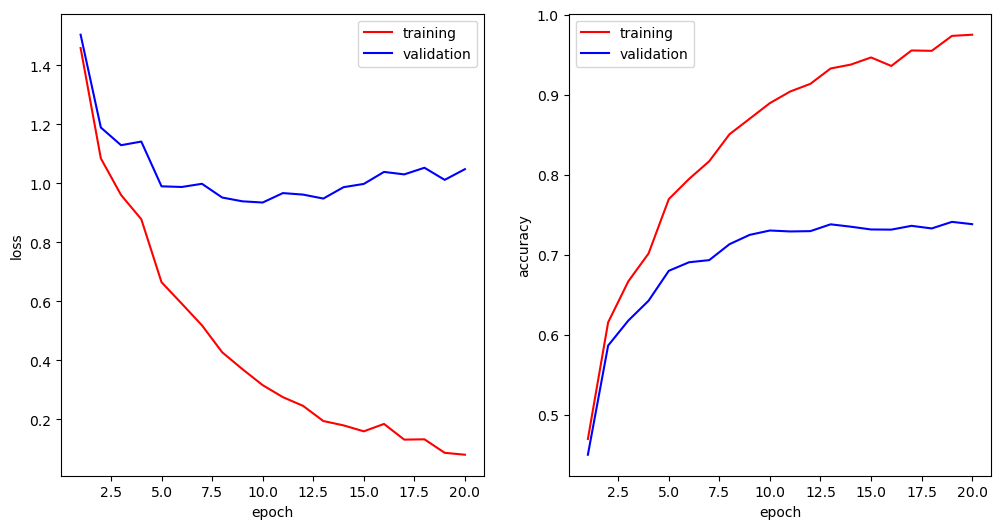

Fold #3
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.2261, Accuracy = 0.5806
client 2 : Loss = 1.1836, Accuracy = 0.5952
client 3 : Loss = 1.3710, Accuracy = 0.5286
client 4 : Loss = 1.3260, Accuracy = 0.5344
client 5 : Loss = 1.2335, Accuracy = 0.5664
client 6 : Loss = 1.3036, Accuracy = 0.5445
client 7 : Loss = 1.1839, Accuracy = 0.5858
client 8 : Loss = 1.3037, Accuracy = 0.5565

Server :
    - training loss = 1.4658
    - training accuracy = 0.4721
    - validation loss = 1.5013
    - validation accuracy = 0.4649
        
>>> Round 2 ...
client 1 : Loss = 0.9989, Accuracy = 0.6462
client 2 : Loss = 0.9047, Accuracy = 0.6814
client 3 : Loss = 1.0405, Accuracy = 0.6495
client 4 : Loss = 0.9109, Accuracy = 0.6715
client 5 : Loss = 0.9522, Accuracy = 0.6655
client 6 : Loss = 0.8905, Accuracy = 0.6912
clie

client 6 : Loss = 0.2832, Accuracy = 0.9041
client 7 : Loss = 0.0475, Accuracy = 0.9908
client 8 : Loss = 0.2166, Accuracy = 0.9310

Server :
    - training loss = 0.1573
    - training accuracy = 0.9467
    - validation loss = 0.9044
    - validation accuracy = 0.7458
        
>>> Round 17 ...
client 1 : Loss = 0.1537, Accuracy = 0.9532
client 2 : Loss = 0.0432, Accuracy = 0.9875
client 3 : Loss = 0.0842, Accuracy = 0.9765
client 4 : Loss = 0.2294, Accuracy = 0.9236
client 5 : Loss = 0.0437, Accuracy = 0.9898
client 6 : Loss = 0.0534, Accuracy = 0.9877
client 7 : Loss = 0.0484, Accuracy = 0.9895
client 8 : Loss = 0.1351, Accuracy = 0.9542

Server :
    - training loss = 0.1632
    - training accuracy = 0.9446
    - validation loss = 0.9555
    - validation accuracy = 0.7406
        
>>> Round 18 ...
client 1 : Loss = 0.2171, Accuracy = 0.9314
client 2 : Loss = 0.1339, Accuracy = 0.9600
client 3 : Loss = 0.0579, Accuracy = 0.9887
client 4 : Loss = 0.1747, Accuracy = 0.9500
client 5 : L

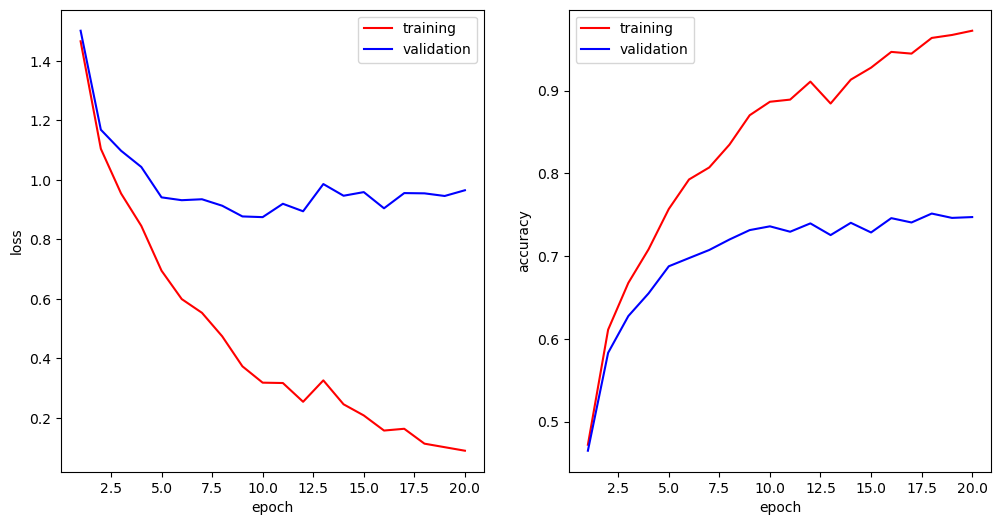

Fold #4
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.2438, Accuracy = 0.5701
client 2 : Loss = 1.2252, Accuracy = 0.5717
client 3 : Loss = 1.1800, Accuracy = 0.5887
client 4 : Loss = 1.1955, Accuracy = 0.5784
client 5 : Loss = 1.0990, Accuracy = 0.6071
client 6 : Loss = 1.4346, Accuracy = 0.5135
client 7 : Loss = 1.1908, Accuracy = 0.5805
client 8 : Loss = 1.2410, Accuracy = 0.5739

Server :
    - training loss = 1.5612
    - training accuracy = 0.4525
    - validation loss = 1.6147
    - validation accuracy = 0.4420
        
>>> Round 2 ...
client 1 : Loss = 0.9354, Accuracy = 0.6727
client 2 : Loss = 0.9060, Accuracy = 0.6771
client 3 : Loss = 0.9930, Accuracy = 0.6588
client 4 : Loss = 0.9282, Accuracy = 0.6702
client 5 : Loss = 0.8887, Accuracy = 0.6878
client 6 : Loss = 0.9438, Accuracy = 0.6669
clie

client 6 : Loss = 0.5169, Accuracy = 0.8398
client 7 : Loss = 0.1179, Accuracy = 0.9643
client 8 : Loss = 0.0600, Accuracy = 0.9837

Server :
    - training loss = 0.1823
    - training accuracy = 0.9365
    - validation loss = 1.0331
    - validation accuracy = 0.7275
        
>>> Round 17 ...
client 1 : Loss = 0.1385, Accuracy = 0.9572
client 2 : Loss = 0.0747, Accuracy = 0.9777
client 3 : Loss = 0.0686, Accuracy = 0.9836
client 4 : Loss = 0.0647, Accuracy = 0.9814
client 5 : Loss = 0.0357, Accuracy = 0.9928
client 6 : Loss = 0.2207, Accuracy = 0.9301
client 7 : Loss = 0.1250, Accuracy = 0.9623
client 8 : Loss = 0.1528, Accuracy = 0.9523

Server :
    - training loss = 0.1478
    - training accuracy = 0.9491
    - validation loss = 0.9799
    - validation accuracy = 0.7387
        
>>> Round 18 ...
client 1 : Loss = 0.0555, Accuracy = 0.9854
client 2 : Loss = 0.1925, Accuracy = 0.9375
client 3 : Loss = 0.1059, Accuracy = 0.9662
client 4 : Loss = 0.2080, Accuracy = 0.9289
client 5 : L

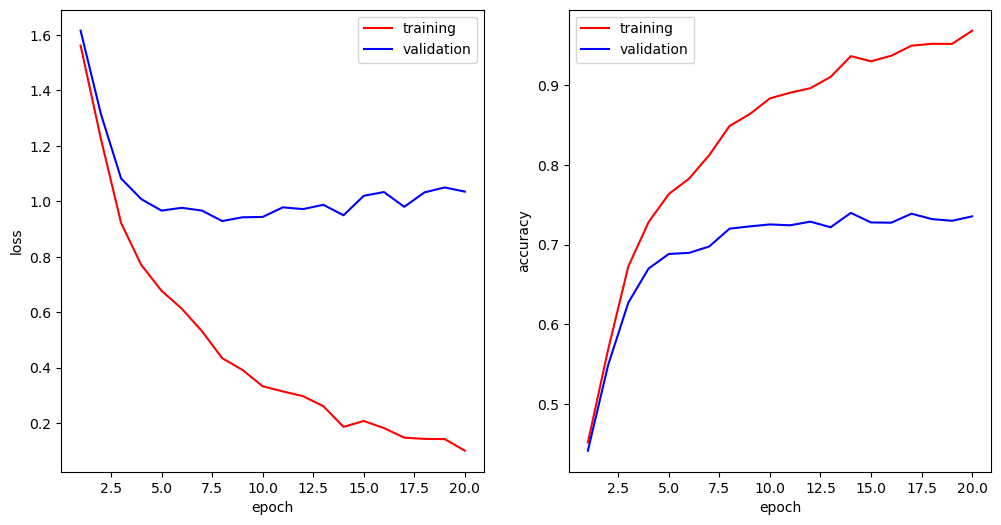

Fold #0
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.4842, Accuracy = 0.4791
client 2 : Loss = 1.4931, Accuracy = 0.4682
client 3 : Loss = 1.5177, Accuracy = 0.4624
client 4 : Loss = 1.4854, Accuracy = 0.4838
client 5 : Loss = 1.4877, Accuracy = 0.4691
client 6 : Loss = 1.5183, Accuracy = 0.4599
client 7 : Loss = 1.4821, Accuracy = 0.4814
client 8 : Loss = 1.4992, Accuracy = 0.4613

Server :
    - training loss = 1.5172
    - training accuracy = 0.4553
    - validation loss = 1.5651
    - validation accuracy = 0.4334
        
>>> Round 2 ...
client 1 : Loss = 1.2958, Accuracy = 0.5337
client 2 : Loss = 1.2885, Accuracy = 0.5483
client 3 : Loss = 1.3068, Accuracy = 0.5321
client 4 : Loss = 1.2721, Accuracy = 0.5584
client 5 : Loss = 1.2909, Accuracy = 0.5447
client 6 : Loss = 1.3046, Accuracy = 0.5323
clie

client 6 : Loss = 0.5505, Accuracy = 0.8037
client 7 : Loss = 0.5051, Accuracy = 0.8333
client 8 : Loss = 0.5332, Accuracy = 0.8223

Server :
    - training loss = 0.5912
    - training accuracy = 0.8014
    - validation loss = 0.9795
    - validation accuracy = 0.6628
        
>>> Round 17 ...
client 1 : Loss = 0.5474, Accuracy = 0.8188
client 2 : Loss = 0.4894, Accuracy = 0.8364
client 3 : Loss = 0.4916, Accuracy = 0.8346
client 4 : Loss = 0.4959, Accuracy = 0.8352
client 5 : Loss = 0.4808, Accuracy = 0.8363
client 6 : Loss = 0.4719, Accuracy = 0.8435
client 7 : Loss = 0.4947, Accuracy = 0.8330
client 8 : Loss = 0.5119, Accuracy = 0.8299

Server :
    - training loss = 0.5598
    - training accuracy = 0.8123
    - validation loss = 0.9701
    - validation accuracy = 0.6683
        
>>> Round 18 ...
client 1 : Loss = 0.4662, Accuracy = 0.8456
client 2 : Loss = 0.4743, Accuracy = 0.8477
client 3 : Loss = 0.4760, Accuracy = 0.8411
client 4 : Loss = 0.4651, Accuracy = 0.8510
client 5 : L

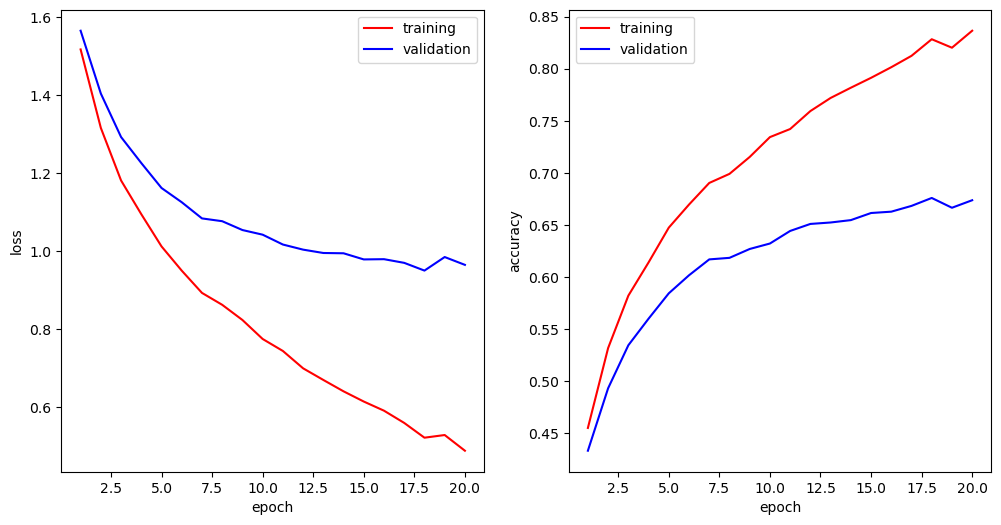

Fold #1
client 1 : 5002 samples
client 2 : 4996 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4996 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.4668, Accuracy = 0.4814
client 2 : Loss = 1.5659, Accuracy = 0.4516
client 3 : Loss = 1.4769, Accuracy = 0.4773
client 4 : Loss = 1.5017, Accuracy = 0.4566
client 5 : Loss = 1.4412, Accuracy = 0.4813
client 6 : Loss = 1.5037, Accuracy = 0.4652
client 7 : Loss = 1.5692, Accuracy = 0.4494
client 8 : Loss = 1.4834, Accuracy = 0.4634

Server :
    - training loss = 1.5073
    - training accuracy = 0.4566
    - validation loss = 1.5722
    - validation accuracy = 0.4347
        
>>> Round 2 ...
client 1 : Loss = 1.2632, Accuracy = 0.5397
client 2 : Loss = 1.3080, Accuracy = 0.5232
client 3 : Loss = 1.2524, Accuracy = 0.5554
client 4 : Loss = 1.3055, Accuracy = 0.5365
client 5 : Loss = 1.2819, Accuracy = 0.5469
client 6 : Loss = 1.2652, Accuracy = 0.5577
clie

client 6 : Loss = 0.5114, Accuracy = 0.8292
client 7 : Loss = 0.5956, Accuracy = 0.8004
client 8 : Loss = 0.5054, Accuracy = 0.8261

Server :
    - training loss = 0.6256
    - training accuracy = 0.7885
    - validation loss = 1.0186
    - validation accuracy = 0.6537
        
>>> Round 17 ...
client 1 : Loss = 0.5020, Accuracy = 0.8366
client 2 : Loss = 0.5351, Accuracy = 0.8203
client 3 : Loss = 0.4648, Accuracy = 0.8534
client 4 : Loss = 0.5192, Accuracy = 0.8254
client 5 : Loss = 0.5047, Accuracy = 0.8312
client 6 : Loss = 0.5089, Accuracy = 0.8353
client 7 : Loss = 0.6162, Accuracy = 0.7957
client 8 : Loss = 0.4877, Accuracy = 0.8299

Server :
    - training loss = 0.5757
    - training accuracy = 0.8040
    - validation loss = 0.9950
    - validation accuracy = 0.6606
        
>>> Round 18 ...
client 1 : Loss = 0.4544, Accuracy = 0.8534
client 2 : Loss = 0.5234, Accuracy = 0.8225
client 3 : Loss = 0.4624, Accuracy = 0.8525
client 4 : Loss = 0.4827, Accuracy = 0.8402
client 5 : L

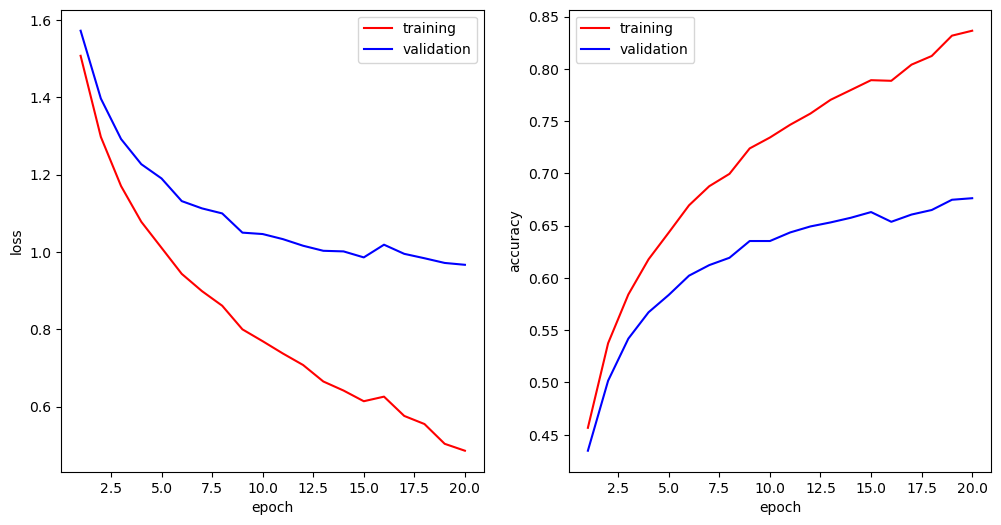

Fold #2
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.4914, Accuracy = 0.4590
client 2 : Loss = 1.4807, Accuracy = 0.4734
client 3 : Loss = 1.4845, Accuracy = 0.4699
client 4 : Loss = 1.4600, Accuracy = 0.4842
client 5 : Loss = 1.5275, Accuracy = 0.4553
client 6 : Loss = 1.4653, Accuracy = 0.4738
client 7 : Loss = 1.4848, Accuracy = 0.4848
client 8 : Loss = 1.5128, Accuracy = 0.4625

Server :
    - training loss = 1.4938
    - training accuracy = 0.4607
    - validation loss = 1.5461
    - validation accuracy = 0.4391
        
>>> Round 2 ...
client 1 : Loss = 1.2912, Accuracy = 0.5406
client 2 : Loss = 1.2514, Accuracy = 0.5567
client 3 : Loss = 1.2741, Accuracy = 0.5430
client 4 : Loss = 1.2558, Accuracy = 0.5563
client 5 : Loss = 1.2972, Accuracy = 0.5349
client 6 : Loss = 1.2829, Accuracy = 0.5432
clie

client 6 : Loss = 0.5083, Accuracy = 0.8342
client 7 : Loss = 0.4713, Accuracy = 0.8431
client 8 : Loss = 0.4908, Accuracy = 0.8346

Server :
    - training loss = 0.5592
    - training accuracy = 0.8125
    - validation loss = 1.0007
    - validation accuracy = 0.6607
        
>>> Round 17 ...
client 1 : Loss = 0.5097, Accuracy = 0.8293
client 2 : Loss = 0.5016, Accuracy = 0.8347
client 3 : Loss = 0.4785, Accuracy = 0.8436
client 4 : Loss = 0.4953, Accuracy = 0.8339
client 5 : Loss = 0.4647, Accuracy = 0.8498
client 6 : Loss = 0.4719, Accuracy = 0.8482
client 7 : Loss = 0.5306, Accuracy = 0.8281
client 8 : Loss = 0.4833, Accuracy = 0.8330

Server :
    - training loss = 0.5661
    - training accuracy = 0.8080
    - validation loss = 1.0241
    - validation accuracy = 0.6530
        
>>> Round 18 ...
client 1 : Loss = 0.4238, Accuracy = 0.8631
client 2 : Loss = 0.4403, Accuracy = 0.8572
client 3 : Loss = 0.4752, Accuracy = 0.8414
client 4 : Loss = 0.4471, Accuracy = 0.8556
client 5 : L

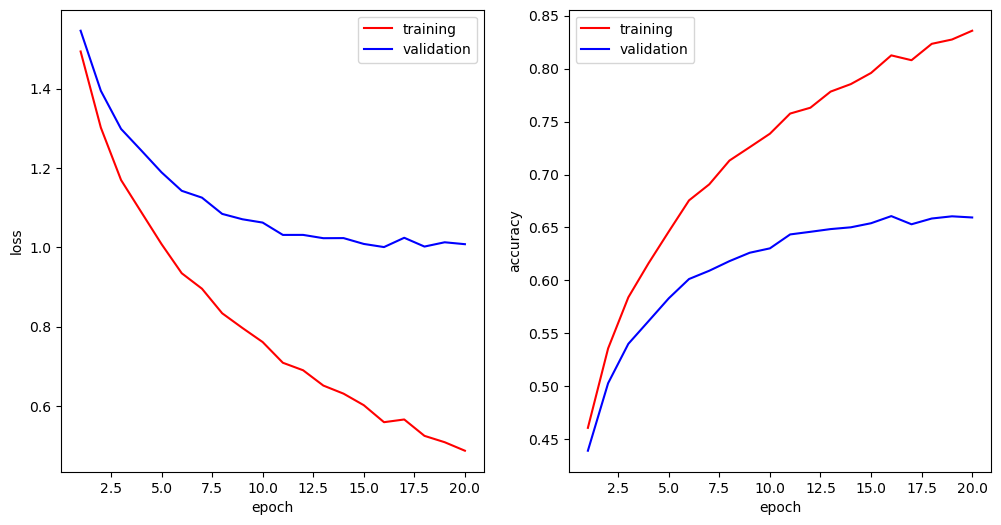

Fold #3
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.5171, Accuracy = 0.4484
client 2 : Loss = 1.4824, Accuracy = 0.4705
client 3 : Loss = 1.5156, Accuracy = 0.4629
client 4 : Loss = 1.4809, Accuracy = 0.4832
client 5 : Loss = 1.5267, Accuracy = 0.4611
client 6 : Loss = 1.4992, Accuracy = 0.4688
client 7 : Loss = 1.5018, Accuracy = 0.4655
client 8 : Loss = 1.5328, Accuracy = 0.4522

Server :
    - training loss = 1.5098
    - training accuracy = 0.4563
    - validation loss = 1.5692
    - validation accuracy = 0.4303
        
>>> Round 2 ...
client 1 : Loss = 1.2936, Accuracy = 0.5421
client 2 : Loss = 1.2835, Accuracy = 0.5451
client 3 : Loss = 1.2992, Accuracy = 0.5319
client 4 : Loss = 1.3325, Accuracy = 0.5334
client 5 : Loss = 1.2738, Accuracy = 0.5419
client 6 : Loss = 1.2669, Accuracy = 0.5395
clie

client 6 : Loss = 0.5403, Accuracy = 0.8184
client 7 : Loss = 0.5104, Accuracy = 0.8304
client 8 : Loss = 0.5321, Accuracy = 0.8292

Server :
    - training loss = 0.5897
    - training accuracy = 0.7996
    - validation loss = 0.9684
    - validation accuracy = 0.6649
        
>>> Round 17 ...
client 1 : Loss = 0.5316, Accuracy = 0.8167
client 2 : Loss = 0.4797, Accuracy = 0.8420
client 3 : Loss = 0.5148, Accuracy = 0.8259
client 4 : Loss = 0.4924, Accuracy = 0.8357
client 5 : Loss = 0.5172, Accuracy = 0.8296
client 6 : Loss = 0.4906, Accuracy = 0.8391
client 7 : Loss = 0.5181, Accuracy = 0.8267
client 8 : Loss = 0.5203, Accuracy = 0.8211

Server :
    - training loss = 0.5971
    - training accuracy = 0.7944
    - validation loss = 0.9942
    - validation accuracy = 0.6558
        
>>> Round 18 ...
client 1 : Loss = 0.5152, Accuracy = 0.8256
client 2 : Loss = 0.4883, Accuracy = 0.8334
client 3 : Loss = 0.5173, Accuracy = 0.8240
client 4 : Loss = 0.5005, Accuracy = 0.8328
client 5 : L

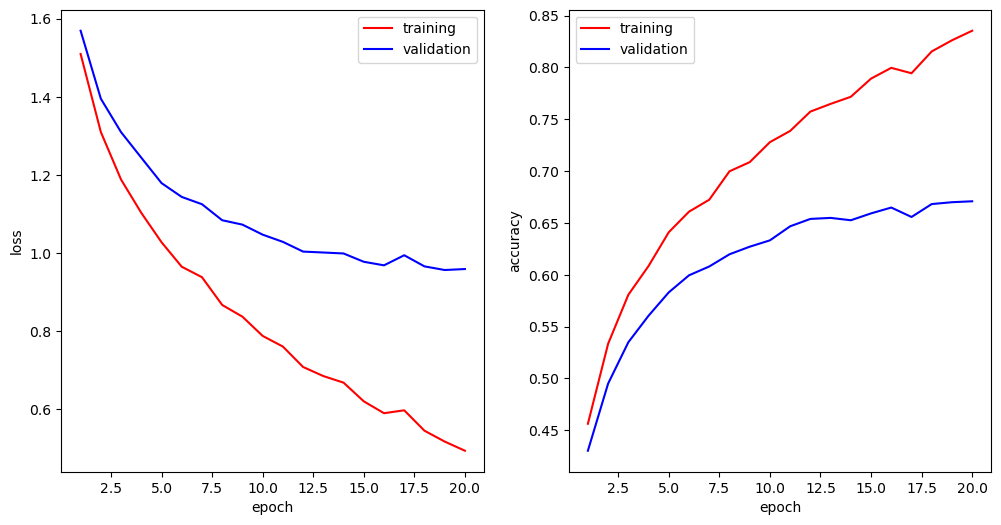

Fold #4
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.4887, Accuracy = 0.4736
client 2 : Loss = 1.5362, Accuracy = 0.4584
client 3 : Loss = 1.4867, Accuracy = 0.4717
client 4 : Loss = 1.4921, Accuracy = 0.4674
client 5 : Loss = 1.4665, Accuracy = 0.4717
client 6 : Loss = 1.4962, Accuracy = 0.4817
client 7 : Loss = 1.4913, Accuracy = 0.4848
client 8 : Loss = 1.4802, Accuracy = 0.4689

Server :
    - training loss = 1.5129
    - training accuracy = 0.4511
    - validation loss = 1.5690
    - validation accuracy = 0.4325
        
>>> Round 2 ...
client 1 : Loss = 1.2926, Accuracy = 0.5373
client 2 : Loss = 1.2746, Accuracy = 0.5340
client 3 : Loss = 1.2978, Accuracy = 0.5371
client 4 : Loss = 1.2793, Accuracy = 0.5416
client 5 : Loss = 1.2858, Accuracy = 0.5382
client 6 : Loss = 1.2658, Accuracy = 0.5589
clie

client 6 : Loss = 0.5080, Accuracy = 0.8291
client 7 : Loss = 0.5089, Accuracy = 0.8303
client 8 : Loss = 0.5311, Accuracy = 0.8223

Server :
    - training loss = 0.5776
    - training accuracy = 0.8058
    - validation loss = 0.9958
    - validation accuracy = 0.6617
        
>>> Round 17 ...
client 1 : Loss = 0.5267, Accuracy = 0.8250
client 2 : Loss = 0.4784, Accuracy = 0.8471
client 3 : Loss = 0.5010, Accuracy = 0.8309
client 4 : Loss = 0.5046, Accuracy = 0.8333
client 5 : Loss = 0.4864, Accuracy = 0.8371
client 6 : Loss = 0.5282, Accuracy = 0.8200
client 7 : Loss = 0.4778, Accuracy = 0.8443
client 8 : Loss = 0.4465, Accuracy = 0.8512

Server :
    - training loss = 0.5458
    - training accuracy = 0.8157
    - validation loss = 0.9869
    - validation accuracy = 0.6644
        
>>> Round 18 ...
client 1 : Loss = 0.4586, Accuracy = 0.8531
client 2 : Loss = 0.4678, Accuracy = 0.8447
client 3 : Loss = 0.4694, Accuracy = 0.8459
client 4 : Loss = 0.4563, Accuracy = 0.8451
client 5 : L

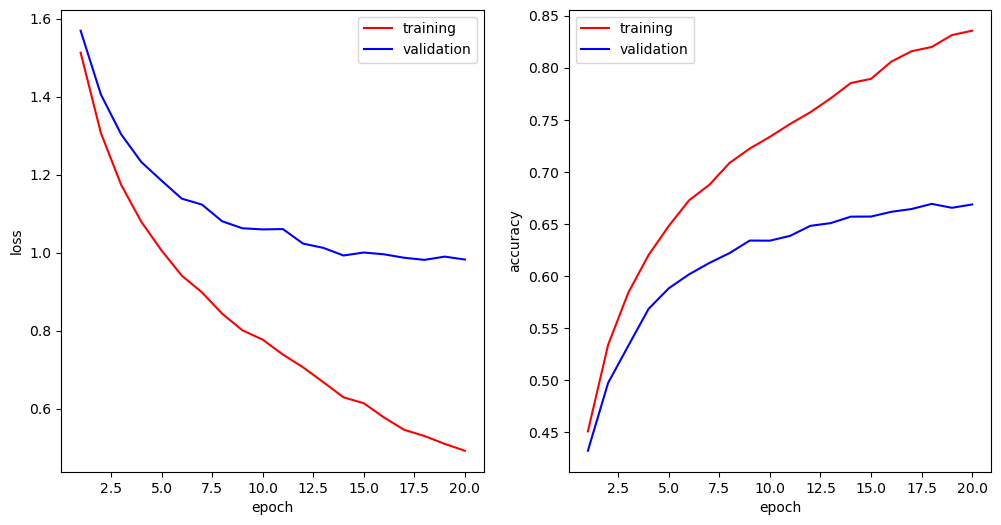

Fold #0
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 2.3640, Accuracy = 0.2184
client 2 : Loss = 2.3266, Accuracy = 0.2212
client 3 : Loss = 2.3180, Accuracy = 0.2208
client 4 : Loss = 2.3400, Accuracy = 0.2275
client 5 : Loss = 2.3736, Accuracy = 0.2084
client 6 : Loss = 2.3627, Accuracy = 0.2068
client 7 : Loss = 2.4021, Accuracy = 0.2082
client 8 : Loss = 2.3650, Accuracy = 0.2109

Server :
    - training loss = 2.0498
    - training accuracy = 0.2629
    - validation loss = 2.0714
    - validation accuracy = 0.2563
        
>>> Round 2 ...
client 1 : Loss = 2.1535, Accuracy = 0.2674
client 2 : Loss = 2.1455, Accuracy = 0.2707
client 3 : Loss = 2.1562, Accuracy = 0.2759
client 4 : Loss = 2.1678, Accuracy = 0.2627
client 5 : Loss = 2.1593, Accuracy = 0.2617
client 6 : Loss = 2.1669, Accuracy = 0.2648
clie

client 6 : Loss = 1.4986, Accuracy = 0.4592
client 7 : Loss = 1.4984, Accuracy = 0.4622
client 8 : Loss = 1.5057, Accuracy = 0.4568

Server :
    - training loss = 1.3020
    - training accuracy = 0.5376
    - validation loss = 1.3941
    - validation accuracy = 0.4991
        
>>> Round 17 ...
client 1 : Loss = 1.4843, Accuracy = 0.4639
client 2 : Loss = 1.4622, Accuracy = 0.4841
client 3 : Loss = 1.4250, Accuracy = 0.4962
client 4 : Loss = 1.4711, Accuracy = 0.4803
client 5 : Loss = 1.4990, Accuracy = 0.4684
client 6 : Loss = 1.4594, Accuracy = 0.4748
client 7 : Loss = 1.4566, Accuracy = 0.4781
client 8 : Loss = 1.4943, Accuracy = 0.4744

Server :
    - training loss = 1.2843
    - training accuracy = 0.5457
    - validation loss = 1.3803
    - validation accuracy = 0.4994
        
>>> Round 18 ...
client 1 : Loss = 1.4624, Accuracy = 0.4845
client 2 : Loss = 1.4221, Accuracy = 0.4932
client 3 : Loss = 1.4438, Accuracy = 0.4799
client 4 : Loss = 1.4607, Accuracy = 0.4799
client 5 : L

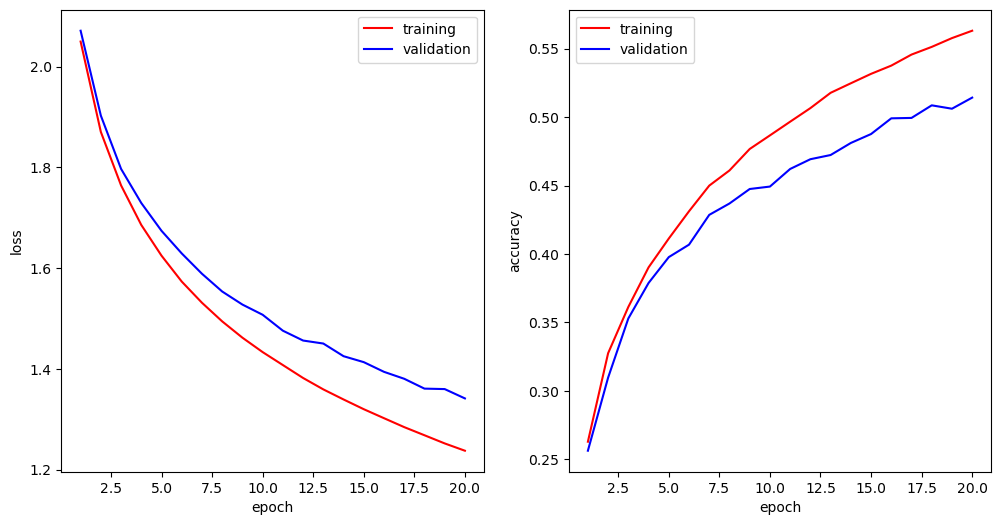

Fold #1
client 1 : 5002 samples
client 2 : 4996 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4996 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 2.3370, Accuracy = 0.2182
client 2 : Loss = 2.3068, Accuracy = 0.2367
client 3 : Loss = 2.3015, Accuracy = 0.2304
client 4 : Loss = 2.3010, Accuracy = 0.2369
client 5 : Loss = 2.3369, Accuracy = 0.2214
client 6 : Loss = 2.3076, Accuracy = 0.2327
client 7 : Loss = 2.3064, Accuracy = 0.2254
client 8 : Loss = 2.3083, Accuracy = 0.2279

Server :
    - training loss = 2.0213
    - training accuracy = 0.2719
    - validation loss = 2.0293
    - validation accuracy = 0.2747
        
>>> Round 2 ...
client 1 : Loss = 2.1210, Accuracy = 0.2753
client 2 : Loss = 2.0740, Accuracy = 0.2893
client 3 : Loss = 2.0896, Accuracy = 0.2896
client 4 : Loss = 2.0832, Accuracy = 0.2855
client 5 : Loss = 2.1189, Accuracy = 0.2850
client 6 : Loss = 2.1111, Accuracy = 0.2851
clie

client 6 : Loss = 1.4694, Accuracy = 0.4762
client 7 : Loss = 1.4769, Accuracy = 0.4803
client 8 : Loss = 1.4780, Accuracy = 0.4775

Server :
    - training loss = 1.2812
    - training accuracy = 0.5491
    - validation loss = 1.3849
    - validation accuracy = 0.5111
        
>>> Round 17 ...
client 1 : Loss = 1.4473, Accuracy = 0.4823
client 2 : Loss = 1.4562, Accuracy = 0.4859
client 3 : Loss = 1.4239, Accuracy = 0.4920
client 4 : Loss = 1.4367, Accuracy = 0.4908
client 5 : Loss = 1.4566, Accuracy = 0.4891
client 6 : Loss = 1.4189, Accuracy = 0.4958
client 7 : Loss = 1.4733, Accuracy = 0.4830
client 8 : Loss = 1.4888, Accuracy = 0.4764

Server :
    - training loss = 1.2618
    - training accuracy = 0.5543
    - validation loss = 1.3720
    - validation accuracy = 0.5118
        
>>> Round 18 ...
client 1 : Loss = 1.4474, Accuracy = 0.4760
client 2 : Loss = 1.4002, Accuracy = 0.5117
client 3 : Loss = 1.4122, Accuracy = 0.4952
client 4 : Loss = 1.3929, Accuracy = 0.5029
client 5 : L

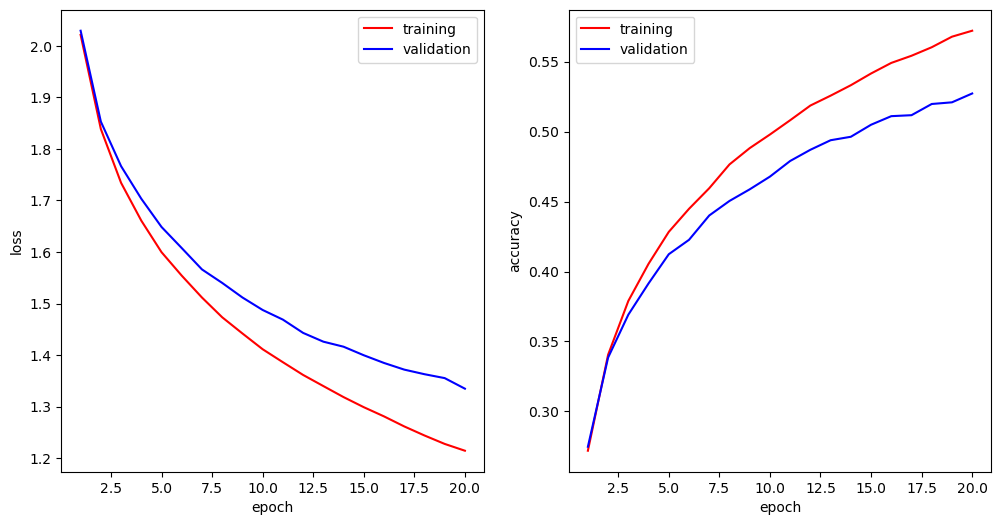

Fold #2
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 2.2769, Accuracy = 0.2340
client 2 : Loss = 2.3109, Accuracy = 0.2336
client 3 : Loss = 2.2940, Accuracy = 0.2283
client 4 : Loss = 2.2833, Accuracy = 0.2306
client 5 : Loss = 2.3172, Accuracy = 0.2223
client 6 : Loss = 2.3224, Accuracy = 0.2227
client 7 : Loss = 2.2635, Accuracy = 0.2376
client 8 : Loss = 2.3289, Accuracy = 0.2170

Server :
    - training loss = 2.0063
    - training accuracy = 0.2724
    - validation loss = 2.0040
    - validation accuracy = 0.2716
        
>>> Round 2 ...
client 1 : Loss = 2.0844, Accuracy = 0.2873
client 2 : Loss = 2.0857, Accuracy = 0.2929
client 3 : Loss = 2.0925, Accuracy = 0.2846
client 4 : Loss = 2.0631, Accuracy = 0.2951
client 5 : Loss = 2.1078, Accuracy = 0.2821
client 6 : Loss = 2.1178, Accuracy = 0.2695
clie

client 6 : Loss = 1.4498, Accuracy = 0.4896
client 7 : Loss = 1.4330, Accuracy = 0.4816
client 8 : Loss = 1.4330, Accuracy = 0.4941

Server :
    - training loss = 1.2655
    - training accuracy = 0.5504
    - validation loss = 1.3751
    - validation accuracy = 0.5063
        
>>> Round 17 ...
client 1 : Loss = 1.4225, Accuracy = 0.4908
client 2 : Loss = 1.4095, Accuracy = 0.4972
client 3 : Loss = 1.4130, Accuracy = 0.4959
client 4 : Loss = 1.4565, Accuracy = 0.4778
client 5 : Loss = 1.4337, Accuracy = 0.4862
client 6 : Loss = 1.4302, Accuracy = 0.4934
client 7 : Loss = 1.4064, Accuracy = 0.4991
client 8 : Loss = 1.4655, Accuracy = 0.4826

Server :
    - training loss = 1.2492
    - training accuracy = 0.5561
    - validation loss = 1.3653
    - validation accuracy = 0.5114
        
>>> Round 18 ...
client 1 : Loss = 1.3574, Accuracy = 0.5154
client 2 : Loss = 1.4202, Accuracy = 0.4974
client 3 : Loss = 1.4003, Accuracy = 0.4916
client 4 : Loss = 1.4008, Accuracy = 0.5054
client 5 : L

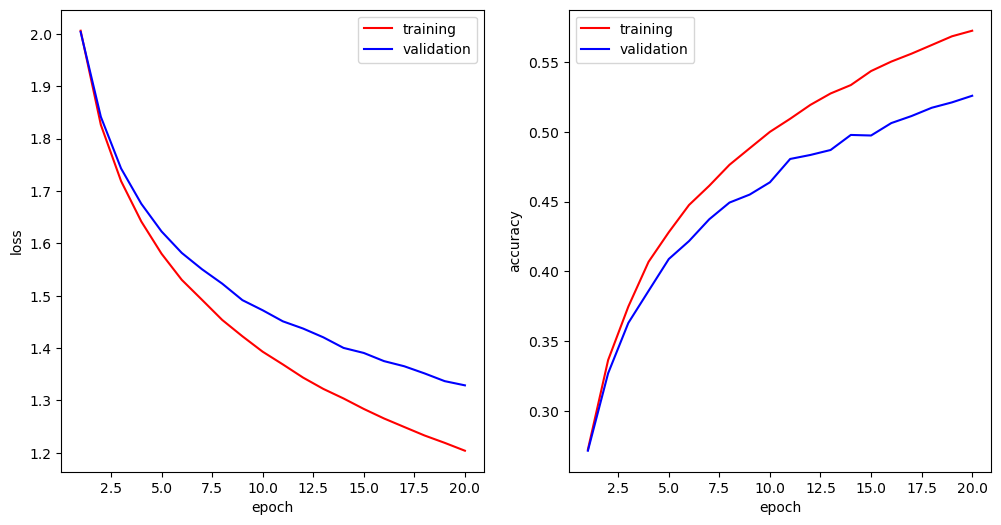

Fold #3
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 2.3730, Accuracy = 0.2118
client 2 : Loss = 2.3751, Accuracy = 0.2116
client 3 : Loss = 2.3666, Accuracy = 0.2043
client 4 : Loss = 2.3568, Accuracy = 0.2189
client 5 : Loss = 2.3961, Accuracy = 0.2204
client 6 : Loss = 2.3530, Accuracy = 0.2146
client 7 : Loss = 2.3709, Accuracy = 0.2104
client 8 : Loss = 2.3939, Accuracy = 0.2198

Server :
    - training loss = 2.0669
    - training accuracy = 0.2590
    - validation loss = 2.0911
    - validation accuracy = 0.2607
        
>>> Round 2 ...
client 1 : Loss = 2.1551, Accuracy = 0.2762
client 2 : Loss = 2.1466, Accuracy = 0.2726
client 3 : Loss = 2.1401, Accuracy = 0.2741
client 4 : Loss = 2.1301, Accuracy = 0.2762
client 5 : Loss = 2.1593, Accuracy = 0.2750
client 6 : Loss = 2.1419, Accuracy = 0.2875
clie

client 6 : Loss = 1.4794, Accuracy = 0.4857
client 7 : Loss = 1.4479, Accuracy = 0.4824
client 8 : Loss = 1.4693, Accuracy = 0.4881

Server :
    - training loss = 1.2723
    - training accuracy = 0.5521
    - validation loss = 1.3781
    - validation accuracy = 0.5125
        
>>> Round 17 ...
client 1 : Loss = 1.4314, Accuracy = 0.4915
client 2 : Loss = 1.4423, Accuracy = 0.4971
client 3 : Loss = 1.4410, Accuracy = 0.4949
client 4 : Loss = 1.4601, Accuracy = 0.4748
client 5 : Loss = 1.4358, Accuracy = 0.5019
client 6 : Loss = 1.4323, Accuracy = 0.4980
client 7 : Loss = 1.4236, Accuracy = 0.4861
client 8 : Loss = 1.4688, Accuracy = 0.4902

Server :
    - training loss = 1.2546
    - training accuracy = 0.5595
    - validation loss = 1.3593
    - validation accuracy = 0.5179
        
>>> Round 18 ...
client 1 : Loss = 1.4226, Accuracy = 0.4935
client 2 : Loss = 1.3801, Accuracy = 0.5144
client 3 : Loss = 1.4340, Accuracy = 0.4915
client 4 : Loss = 1.4038, Accuracy = 0.5029
client 5 : L

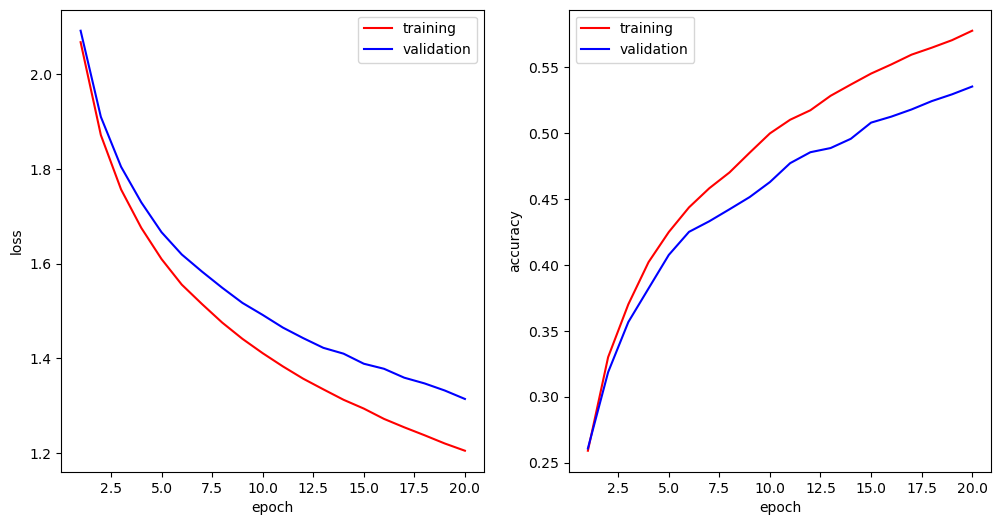

Fold #4
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 2.3521, Accuracy = 0.2090
client 2 : Loss = 2.3571, Accuracy = 0.2182
client 3 : Loss = 2.3398, Accuracy = 0.2260
client 4 : Loss = 2.3500, Accuracy = 0.2307
client 5 : Loss = 2.3864, Accuracy = 0.2109
client 6 : Loss = 2.3348, Accuracy = 0.2135
client 7 : Loss = 2.3723, Accuracy = 0.2180
client 8 : Loss = 2.3815, Accuracy = 0.2042

Server :
    - training loss = 2.0589
    - training accuracy = 0.2614
    - validation loss = 2.0814
    - validation accuracy = 0.2582
        
>>> Round 2 ...
client 1 : Loss = 2.1372, Accuracy = 0.2756
client 2 : Loss = 2.1047, Accuracy = 0.2869
client 3 : Loss = 2.1188, Accuracy = 0.2785
client 4 : Loss = 2.1297, Accuracy = 0.2749
client 5 : Loss = 2.1107, Accuracy = 0.2813
client 6 : Loss = 2.1278, Accuracy = 0.2680
clie

client 6 : Loss = 1.4876, Accuracy = 0.4642
client 7 : Loss = 1.4759, Accuracy = 0.4836
client 8 : Loss = 1.4552, Accuracy = 0.4753

Server :
    - training loss = 1.2853
    - training accuracy = 0.5468
    - validation loss = 1.4154
    - validation accuracy = 0.4958
        
>>> Round 17 ...
client 1 : Loss = 1.4148, Accuracy = 0.4928
client 2 : Loss = 1.4350, Accuracy = 0.4891
client 3 : Loss = 1.4746, Accuracy = 0.4832
client 4 : Loss = 1.4441, Accuracy = 0.4826
client 5 : Loss = 1.4536, Accuracy = 0.4950
client 6 : Loss = 1.4242, Accuracy = 0.4857
client 7 : Loss = 1.4418, Accuracy = 0.4834
client 8 : Loss = 1.4583, Accuracy = 0.4774

Server :
    - training loss = 1.2681
    - training accuracy = 0.5532
    - validation loss = 1.4013
    - validation accuracy = 0.5008
        
>>> Round 18 ...
client 1 : Loss = 1.4217, Accuracy = 0.4914
client 2 : Loss = 1.4411, Accuracy = 0.4822
client 3 : Loss = 1.4173, Accuracy = 0.4896
client 4 : Loss = 1.4417, Accuracy = 0.4934
client 5 : L

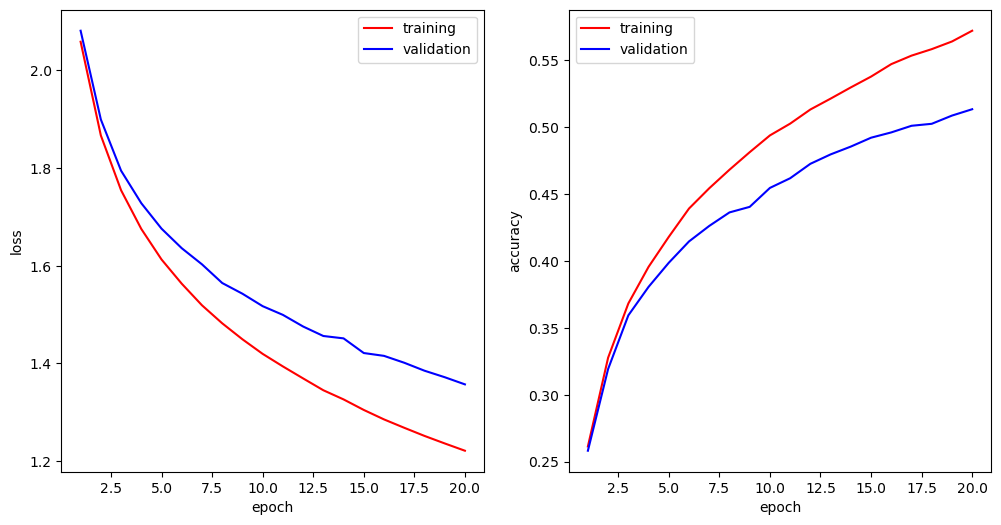

Fold #0
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 2.9176, Accuracy = 0.1139
client 2 : Loss = 2.8915, Accuracy = 0.1193
client 3 : Loss = 2.8825, Accuracy = 0.1164
client 4 : Loss = 2.8912, Accuracy = 0.1195
client 5 : Loss = 2.9004, Accuracy = 0.1184
client 6 : Loss = 2.8822, Accuracy = 0.1271
client 7 : Loss = 2.8666, Accuracy = 0.1178
client 8 : Loss = 2.8753, Accuracy = 0.1246

Server :
    - training loss = 2.5076
    - training accuracy = 0.1322
    - validation loss = 2.4990
    - validation accuracy = 0.1345
        
>>> Round 2 ...
client 1 : Loss = 2.7805, Accuracy = 0.1348
client 2 : Loss = 2.7635, Accuracy = 0.1411
client 3 : Loss = 2.7710, Accuracy = 0.1428
client 4 : Loss = 2.7673, Accuracy = 0.1328
client 5 : Loss = 2.7909, Accuracy = 0.1316
client 6 : Loss = 2.7490, Accuracy = 0.1482
clie

client 6 : Loss = 2.2289, Accuracy = 0.2414
client 7 : Loss = 2.2330, Accuracy = 0.2483
client 8 : Loss = 2.2352, Accuracy = 0.2451

Server :
    - training loss = 1.8868
    - training accuracy = 0.3241
    - validation loss = 1.8996
    - validation accuracy = 0.3167
        
>>> Round 17 ...
client 1 : Loss = 2.1844, Accuracy = 0.2626
client 2 : Loss = 2.1634, Accuracy = 0.2649
client 3 : Loss = 2.2009, Accuracy = 0.2483
client 4 : Loss = 2.1857, Accuracy = 0.2514
client 5 : Loss = 2.1964, Accuracy = 0.2617
client 6 : Loss = 2.2253, Accuracy = 0.2496
client 7 : Loss = 2.1955, Accuracy = 0.2611
client 8 : Loss = 2.2254, Accuracy = 0.2451

Server :
    - training loss = 1.8703
    - training accuracy = 0.3296
    - validation loss = 1.8866
    - validation accuracy = 0.3216
        
>>> Round 18 ...
client 1 : Loss = 2.1937, Accuracy = 0.2569
client 2 : Loss = 2.1864, Accuracy = 0.2542
client 3 : Loss = 2.1873, Accuracy = 0.2553
client 4 : Loss = 2.2173, Accuracy = 0.2539
client 5 : L

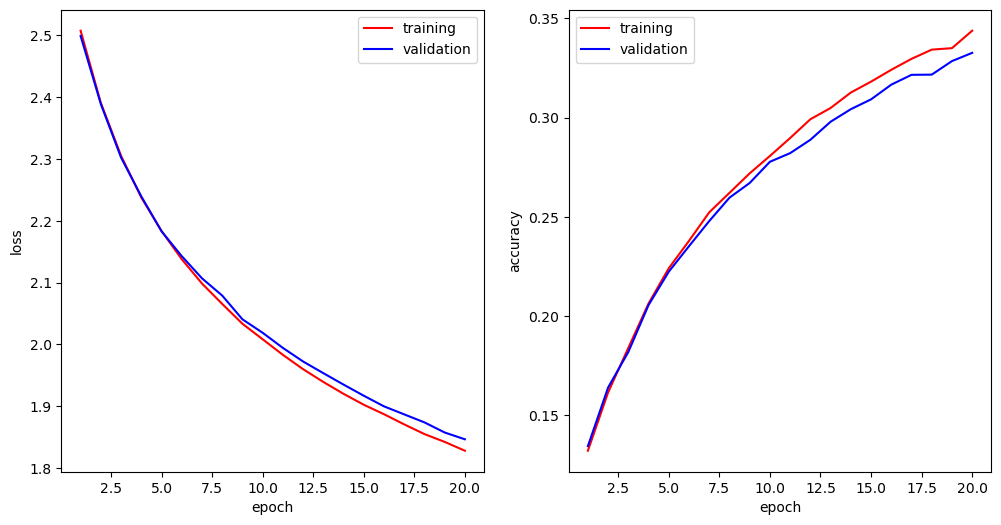

Fold #1
client 1 : 5002 samples
client 2 : 4996 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4996 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 2.9817, Accuracy = 0.1137
client 2 : Loss = 3.0301, Accuracy = 0.1063
client 3 : Loss = 2.9973, Accuracy = 0.1127
client 4 : Loss = 3.0133, Accuracy = 0.0996
client 5 : Loss = 3.0243, Accuracy = 0.1077
client 6 : Loss = 2.9605, Accuracy = 0.1079
client 7 : Loss = 3.0131, Accuracy = 0.1082
client 8 : Loss = 2.9965, Accuracy = 0.1056

Server :
    - training loss = 2.6140
    - training accuracy = 0.1089
    - validation loss = 2.5913
    - validation accuracy = 0.1063
        
>>> Round 2 ...
client 1 : Loss = 2.8277, Accuracy = 0.1215
client 2 : Loss = 2.8485, Accuracy = 0.1213
client 3 : Loss = 2.8882, Accuracy = 0.1160
client 4 : Loss = 2.8882, Accuracy = 0.1137
client 5 : Loss = 2.8779, Accuracy = 0.1227
client 6 : Loss = 2.8799, Accuracy = 0.1184
clie

client 6 : Loss = 2.2666, Accuracy = 0.2556
client 7 : Loss = 2.2570, Accuracy = 0.2299
client 8 : Loss = 2.2736, Accuracy = 0.2307

Server :
    - training loss = 1.9292
    - training accuracy = 0.3057
    - validation loss = 1.9587
    - validation accuracy = 0.2938
        
>>> Round 17 ...
client 1 : Loss = 2.2473, Accuracy = 0.2544
client 2 : Loss = 2.2470, Accuracy = 0.2621
client 3 : Loss = 2.2459, Accuracy = 0.2476
client 4 : Loss = 2.2663, Accuracy = 0.2396
client 5 : Loss = 2.2846, Accuracy = 0.2272
client 6 : Loss = 2.2633, Accuracy = 0.2401
client 7 : Loss = 2.2646, Accuracy = 0.2391
client 8 : Loss = 2.2598, Accuracy = 0.2445

Server :
    - training loss = 1.9140
    - training accuracy = 0.3092
    - validation loss = 1.9389
    - validation accuracy = 0.2981
        
>>> Round 18 ...
client 1 : Loss = 2.2116, Accuracy = 0.2554
client 2 : Loss = 2.2062, Accuracy = 0.2592
client 3 : Loss = 2.2294, Accuracy = 0.2564
client 4 : Loss = 2.2532, Accuracy = 0.2459
client 5 : L

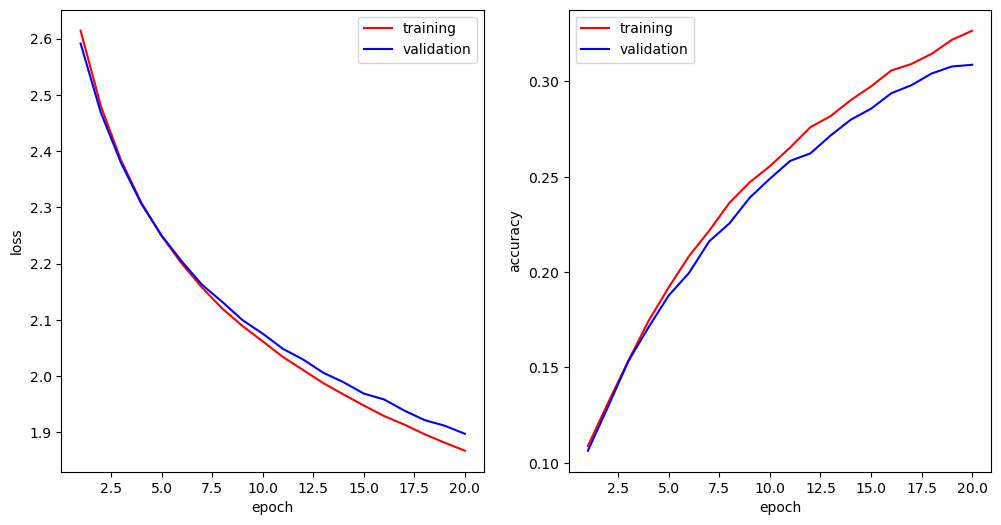

Fold #2
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 2.8437, Accuracy = 0.1168
client 2 : Loss = 2.8827, Accuracy = 0.1193
client 3 : Loss = 2.8439, Accuracy = 0.1236
client 4 : Loss = 2.8402, Accuracy = 0.1152
client 5 : Loss = 2.8333, Accuracy = 0.1257
client 6 : Loss = 2.8500, Accuracy = 0.1248
client 7 : Loss = 2.8788, Accuracy = 0.1202
client 8 : Loss = 2.8492, Accuracy = 0.1205

Server :
    - training loss = 2.4893
    - training accuracy = 0.1311
    - validation loss = 2.4793
    - validation accuracy = 0.1368
        
>>> Round 2 ...
client 1 : Loss = 2.7613, Accuracy = 0.1268
client 2 : Loss = 2.7764, Accuracy = 0.1421
client 3 : Loss = 2.7589, Accuracy = 0.1344
client 4 : Loss = 2.7466, Accuracy = 0.1421
client 5 : Loss = 2.7716, Accuracy = 0.1327
client 6 : Loss = 2.7435, Accuracy = 0.1408
clie

client 6 : Loss = 2.2577, Accuracy = 0.2383
client 7 : Loss = 2.2670, Accuracy = 0.2409
client 8 : Loss = 2.2298, Accuracy = 0.2529

Server :
    - training loss = 1.9226
    - training accuracy = 0.3075
    - validation loss = 1.9379
    - validation accuracy = 0.3032
        
>>> Round 17 ...
client 1 : Loss = 2.2762, Accuracy = 0.2240
client 2 : Loss = 2.2069, Accuracy = 0.2608
client 3 : Loss = 2.2163, Accuracy = 0.2463
client 4 : Loss = 2.2358, Accuracy = 0.2534
client 5 : Loss = 2.2312, Accuracy = 0.2407
client 6 : Loss = 2.2665, Accuracy = 0.2449
client 7 : Loss = 2.2275, Accuracy = 0.2484
client 8 : Loss = 2.2549, Accuracy = 0.2400

Server :
    - training loss = 1.9075
    - training accuracy = 0.3135
    - validation loss = 1.9232
    - validation accuracy = 0.3029
        
>>> Round 18 ...
client 1 : Loss = 2.2298, Accuracy = 0.2512
client 2 : Loss = 2.2316, Accuracy = 0.2501
client 3 : Loss = 2.2424, Accuracy = 0.2422
client 4 : Loss = 2.2040, Accuracy = 0.2580
client 5 : L

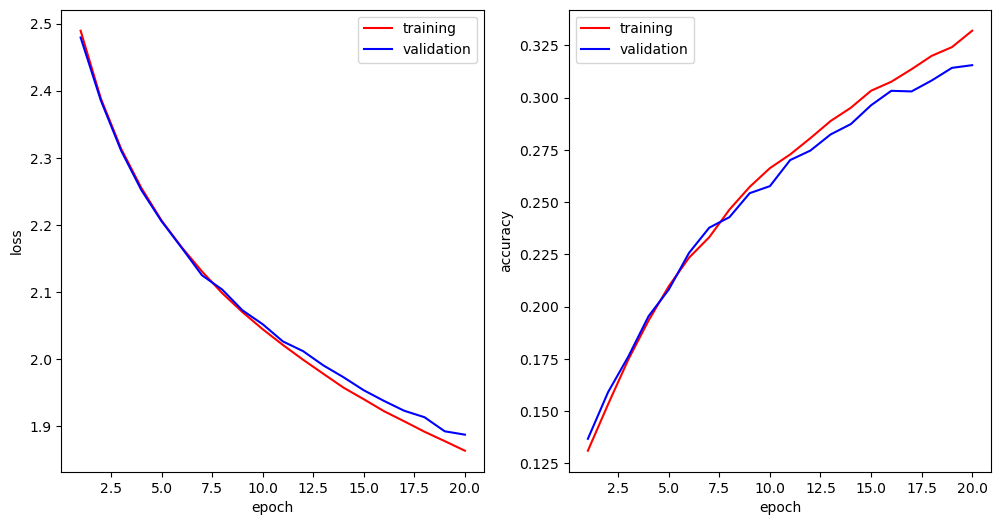

Fold #3
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 2.9089, Accuracy = 0.1131
client 2 : Loss = 2.8393, Accuracy = 0.1228
client 3 : Loss = 2.8718, Accuracy = 0.1170
client 4 : Loss = 2.8513, Accuracy = 0.1264
client 5 : Loss = 2.8811, Accuracy = 0.1113
client 6 : Loss = 2.8187, Accuracy = 0.1211
client 7 : Loss = 2.9016, Accuracy = 0.1113
client 8 : Loss = 2.8880, Accuracy = 0.1147

Server :
    - training loss = 2.4978
    - training accuracy = 0.1264
    - validation loss = 2.5200
    - validation accuracy = 0.1254
        
>>> Round 2 ...
client 1 : Loss = 2.7988, Accuracy = 0.1207
client 2 : Loss = 2.7813, Accuracy = 0.1374
client 3 : Loss = 2.7428, Accuracy = 0.1325
client 4 : Loss = 2.7603, Accuracy = 0.1393
client 5 : Loss = 2.7806, Accuracy = 0.1289
client 6 : Loss = 2.7561, Accuracy = 0.1361
clie

client 6 : Loss = 2.2508, Accuracy = 0.2430
client 7 : Loss = 2.2586, Accuracy = 0.2474
client 8 : Loss = 2.2861, Accuracy = 0.2472

Server :
    - training loss = 1.9203
    - training accuracy = 0.3100
    - validation loss = 1.9583
    - validation accuracy = 0.2980
        
>>> Round 17 ...
client 1 : Loss = 2.2115, Accuracy = 0.2569
client 2 : Loss = 2.2344, Accuracy = 0.2495
client 3 : Loss = 2.2555, Accuracy = 0.2469
client 4 : Loss = 2.2333, Accuracy = 0.2469
client 5 : Loss = 2.2383, Accuracy = 0.2505
client 6 : Loss = 2.2436, Accuracy = 0.2395
client 7 : Loss = 2.2391, Accuracy = 0.2370
client 8 : Loss = 2.2416, Accuracy = 0.2450

Server :
    - training loss = 1.9024
    - training accuracy = 0.3168
    - validation loss = 1.9439
    - validation accuracy = 0.3028
        
>>> Round 18 ...
client 1 : Loss = 2.2432, Accuracy = 0.2512
client 2 : Loss = 2.2114, Accuracy = 0.2534
client 3 : Loss = 2.2446, Accuracy = 0.2413
client 4 : Loss = 2.1828, Accuracy = 0.2564
client 5 : L

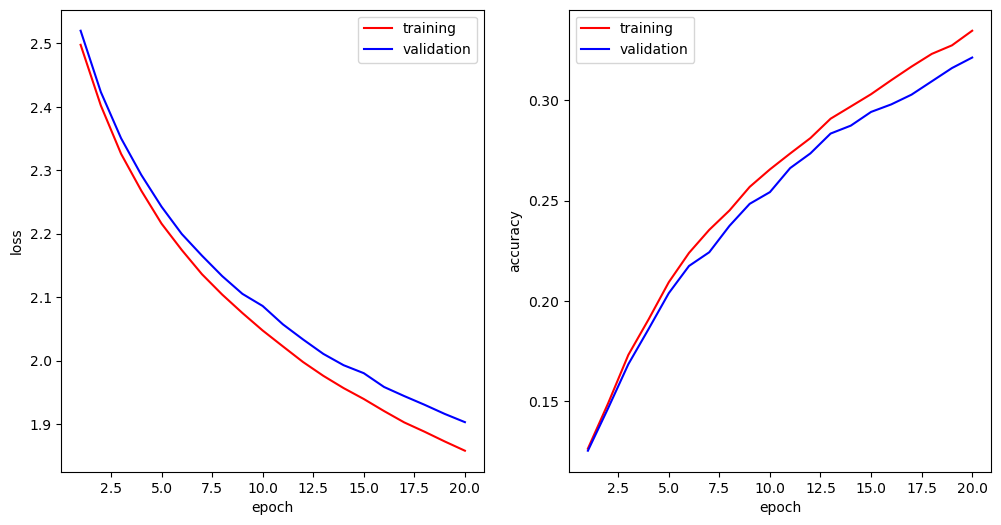

Fold #4
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 2.9500, Accuracy = 0.1121
client 2 : Loss = 2.9898, Accuracy = 0.1070
client 3 : Loss = 2.9048, Accuracy = 0.1174
client 4 : Loss = 2.9449, Accuracy = 0.1125
client 5 : Loss = 2.9559, Accuracy = 0.1136
client 6 : Loss = 2.9828, Accuracy = 0.1141
client 7 : Loss = 2.9779, Accuracy = 0.1082
client 8 : Loss = 2.9424, Accuracy = 0.1164

Server :
    - training loss = 2.5603
    - training accuracy = 0.1194
    - validation loss = 2.5786
    - validation accuracy = 0.1153
        
>>> Round 2 ...
client 1 : Loss = 2.8137, Accuracy = 0.1234
client 2 : Loss = 2.8107, Accuracy = 0.1230
client 3 : Loss = 2.8438, Accuracy = 0.1312
client 4 : Loss = 2.8520, Accuracy = 0.1239
client 5 : Loss = 2.8385, Accuracy = 0.1238
client 6 : Loss = 2.8158, Accuracy = 0.1307
clie

client 6 : Loss = 2.2687, Accuracy = 0.2508
client 7 : Loss = 2.1886, Accuracy = 0.2668
client 8 : Loss = 2.2239, Accuracy = 0.2500

Server :
    - training loss = 1.8947
    - training accuracy = 0.3169
    - validation loss = 1.9243
    - validation accuracy = 0.3116
        
>>> Round 17 ...
client 1 : Loss = 2.2528, Accuracy = 0.2535
client 2 : Loss = 2.2262, Accuracy = 0.2500
client 3 : Loss = 2.2123, Accuracy = 0.2512
client 4 : Loss = 2.2276, Accuracy = 0.2591
client 5 : Loss = 2.2621, Accuracy = 0.2491
client 6 : Loss = 2.2437, Accuracy = 0.2456
client 7 : Loss = 2.2054, Accuracy = 0.2564
client 8 : Loss = 2.1848, Accuracy = 0.2616

Server :
    - training loss = 1.8799
    - training accuracy = 0.3221
    - validation loss = 1.9073
    - validation accuracy = 0.3158
        
>>> Round 18 ...
client 1 : Loss = 2.2236, Accuracy = 0.2502
client 2 : Loss = 2.2136, Accuracy = 0.2523
client 3 : Loss = 2.2141, Accuracy = 0.2625
client 4 : Loss = 2.2104, Accuracy = 0.2629
client 5 : L

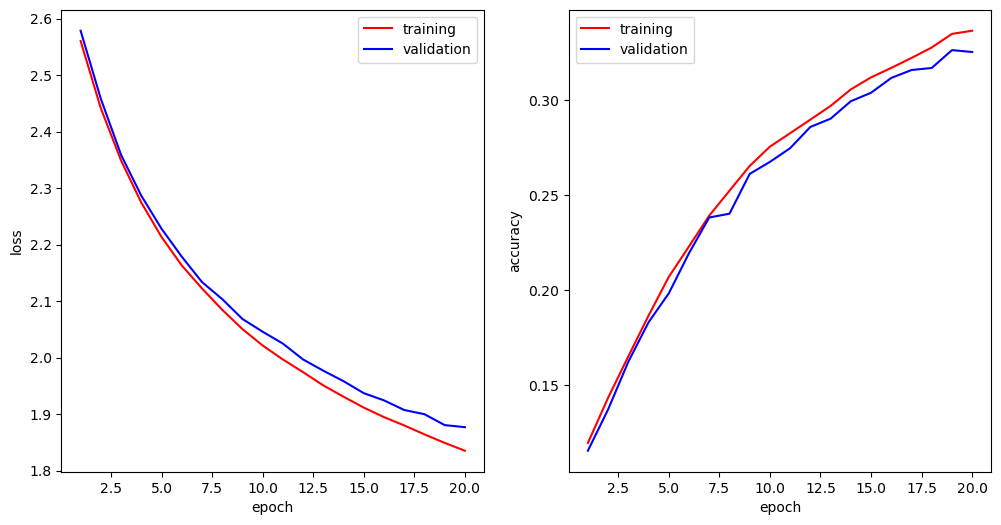

RESULTS
lr = 0.1000 : Accuracy = 0.7403678894042969
lr = 0.0100 : Accuracy = 0.6697982549667358
lr = 0.0010 : Accuracy = 0.523180365562439
lr = 0.0001 : Accuracy = 0.32068830728530884

CPU times: user 2h 16min 10s, sys: 4.59 s, total: 2h 16min 14s
Wall time: 2h 15min 33s


In [10]:
%%time
n_splits = 5
rounds = 20
batch_size = 128
epochs = 5
lrs = [1e-1,1e-2,1e-3,1e-4]
optimizer = optim.SGD

results = []
for lr in lrs:
    res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr)
    results.append((lr,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for lr,res in results:
    print(f"lr = {lr:.4f} : Accuracy = {res}")
print()


# ADAGRAD

# Manual Seeding

In [11]:
seed_generators()

# Data

In [12]:
train_dataset = CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
train_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [13]:
test_dataset = CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())
test_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

# Server & Clients

In [14]:
num_clients = 8
num_classes = 10

## Data repartition among clients

In [15]:
proportions = generate_proportions(num_clients,num_classes,alpha=10e8)
proportions

[tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250])]

# Cross Validation

In [16]:
def run_FedAvg(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optimizer,lr,**kwargs):
    
    train_loader = DeviceDataLoader(DataLoader(train_dataset, batch_size, shuffle=True), device)
    valid_loader = DeviceDataLoader(DataLoader(valid_dataset, batch_size, shuffle=True), device)
    history = []

    server.reset_weights()
    for i in range(rounds):
        print(f'>>> Round {i+1} ...')
        server_params = server.net.state_dict()
        clients_params = []
        for client in clients:
            client.train(device,server_params,epochs,batch_size, optimizer,lr,**kwargs)
        server.merge(clients)
        
        train_loss, train_acc = evaluate(server.net,train_loader)
        valid_loss, valid_acc = evaluate(server.net,valid_loader)
        
        print(f'''
Server :
    - training loss = {train_loss:.4f}
    - training accuracy = {train_acc:.4f}
    - validation loss = {valid_loss:.4f}
    - validation accuracy = {valid_acc:.4f}
        ''')
        
        history.append([train_loss, valid_loss, train_acc, valid_acc])
    return history

In [17]:
def run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr,**kwargs):
    folds = KFold(n_splits=n_splits,shuffle=True,random_state=42).split(np.arange(len(train_dataset)))

    results = []
    for fold, (train_idx,valid_idx) in enumerate(folds):
        print("="*25)
        print(f"Fold #{fold}")
        print("="*25)

        # create train and validation subsets
        train_subset = Subset(train_dataset, train_idx)
        valid_subset = Subset(train_dataset, valid_idx)

        # split data between users
        partition = partition_by_class(train_subset)
        clients = [Client(i,d,model().to(device)) for i,d in enumerate(split(partition,proportions),start=1)]
        server = Server(model().to(device))
        
        for c in clients:
            print(f"client {c.client_id} : {len(c.dataset)} samples")
        print()
        
        history = run_FedAvg(server,clients,device,train_subset,valid_subset,rounds,epochs,batch_size,optimizer,lr,**kwargs)
        
        plot_loss_epoch(history)
        
        results.append(history[-1][-1])
        
        
    return torch.tensor(results).mean()

Fold #0
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.8068, Accuracy = 0.3517
client 2 : Loss = 1.7318, Accuracy = 0.3763
client 3 : Loss = 1.7731, Accuracy = 0.3521
client 4 : Loss = 1.8419, Accuracy = 0.3334
client 5 : Loss = 1.8666, Accuracy = 0.3238
client 6 : Loss = 1.8407, Accuracy = 0.3352
client 7 : Loss = 1.9364, Accuracy = 0.3020
client 8 : Loss = 1.8218, Accuracy = 0.3396

Server :
    - training loss = 2.2812
    - training accuracy = 0.1526
    - validation loss = 2.2778
    - validation accuracy = 0.1554
        
>>> Round 2 ...
client 1 : Loss = 1.6256, Accuracy = 0.4057
client 2 : Loss = 1.6047, Accuracy = 0.4111
client 3 : Loss = 1.6721, Accuracy = 0.3825
client 4 : Loss = 1.6678, Accuracy = 0.3865
client 5 : Loss = 1.6109, Accuracy = 0.4074
client 6 : Loss = 1.7217, Accuracy = 0.3607
clie

client 6 : Loss = 0.5448, Accuracy = 0.7976
client 7 : Loss = 0.5388, Accuracy = 0.8003
client 8 : Loss = 0.6185, Accuracy = 0.7834

Server :
    - training loss = 0.6642
    - training accuracy = 0.7721
    - validation loss = 0.8094
    - validation accuracy = 0.7287
        
>>> Round 17 ...
client 1 : Loss = 0.5424, Accuracy = 0.8039
client 2 : Loss = 0.4750, Accuracy = 0.8198
client 3 : Loss = 0.5617, Accuracy = 0.7992
client 4 : Loss = 0.5372, Accuracy = 0.8088
client 5 : Loss = 0.5783, Accuracy = 0.7924
client 6 : Loss = 0.6037, Accuracy = 0.7912
client 7 : Loss = 0.5422, Accuracy = 0.8028
client 8 : Loss = 0.5124, Accuracy = 0.8105

Server :
    - training loss = 0.6334
    - training accuracy = 0.7805
    - validation loss = 0.7953
    - validation accuracy = 0.7351
        
>>> Round 18 ...
client 1 : Loss = 0.6449, Accuracy = 0.7932
client 2 : Loss = 0.5160, Accuracy = 0.8188
client 3 : Loss = 0.5216, Accuracy = 0.8072
client 4 : Loss = 0.5220, Accuracy = 0.8240
client 5 : L

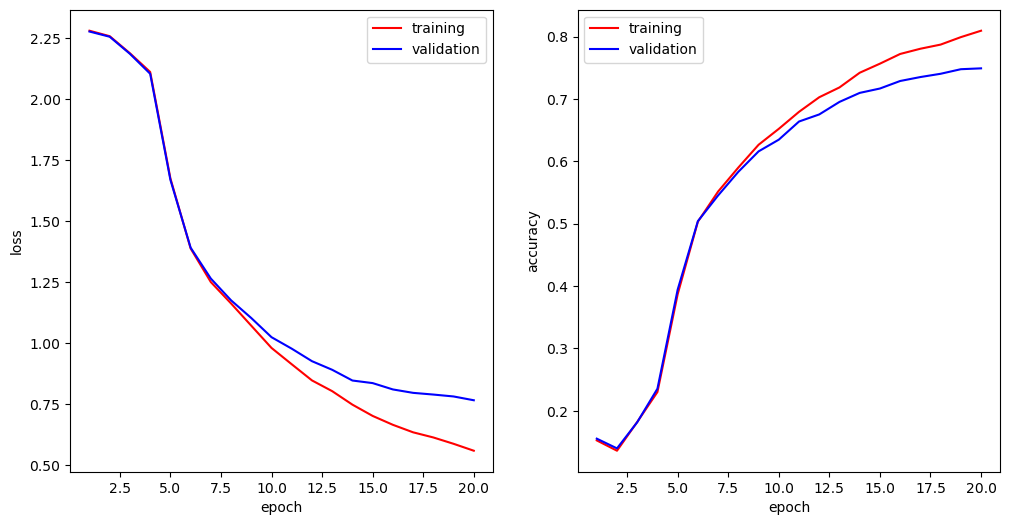

Fold #1
client 1 : 5002 samples
client 2 : 4996 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4996 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.8263, Accuracy = 0.3452
client 2 : Loss = 1.9684, Accuracy = 0.2658
client 3 : Loss = 1.8433, Accuracy = 0.3288
client 4 : Loss = 1.8122, Accuracy = 0.3465
client 5 : Loss = 1.7515, Accuracy = 0.3510
client 6 : Loss = 1.7459, Accuracy = 0.3564
client 7 : Loss = 1.9061, Accuracy = 0.2934
client 8 : Loss = 1.7239, Accuracy = 0.3645

Server :
    - training loss = 2.2987
    - training accuracy = 0.1492
    - validation loss = 2.3044
    - validation accuracy = 0.1477
        
>>> Round 2 ...
client 1 : Loss = 1.6627, Accuracy = 0.3925
client 2 : Loss = 1.6583, Accuracy = 0.4000
client 3 : Loss = 1.6814, Accuracy = 0.3806
client 4 : Loss = 1.6885, Accuracy = 0.3801
client 5 : Loss = 1.6948, Accuracy = 0.3803
client 6 : Loss = 1.6511, Accuracy = 0.3951
clie

client 6 : Loss = 0.5637, Accuracy = 0.8024
client 7 : Loss = 0.5498, Accuracy = 0.8074
client 8 : Loss = 0.5480, Accuracy = 0.8038

Server :
    - training loss = 0.6668
    - training accuracy = 0.7700
    - validation loss = 0.8094
    - validation accuracy = 0.7292
        
>>> Round 17 ...
client 1 : Loss = 0.4804, Accuracy = 0.8289
client 2 : Loss = 0.6596, Accuracy = 0.7725
client 3 : Loss = 0.5062, Accuracy = 0.8237
client 4 : Loss = 0.4878, Accuracy = 0.8193
client 5 : Loss = 0.5361, Accuracy = 0.8036
client 6 : Loss = 0.5061, Accuracy = 0.8108
client 7 : Loss = 0.5986, Accuracy = 0.7908
client 8 : Loss = 0.5178, Accuracy = 0.8114

Server :
    - training loss = 0.6311
    - training accuracy = 0.7839
    - validation loss = 0.7918
    - validation accuracy = 0.7384
        
>>> Round 18 ...
client 1 : Loss = 0.4461, Accuracy = 0.8389
client 2 : Loss = 0.5309, Accuracy = 0.8102
client 3 : Loss = 0.4232, Accuracy = 0.8489
client 4 : Loss = 0.5643, Accuracy = 0.7996
client 5 : L

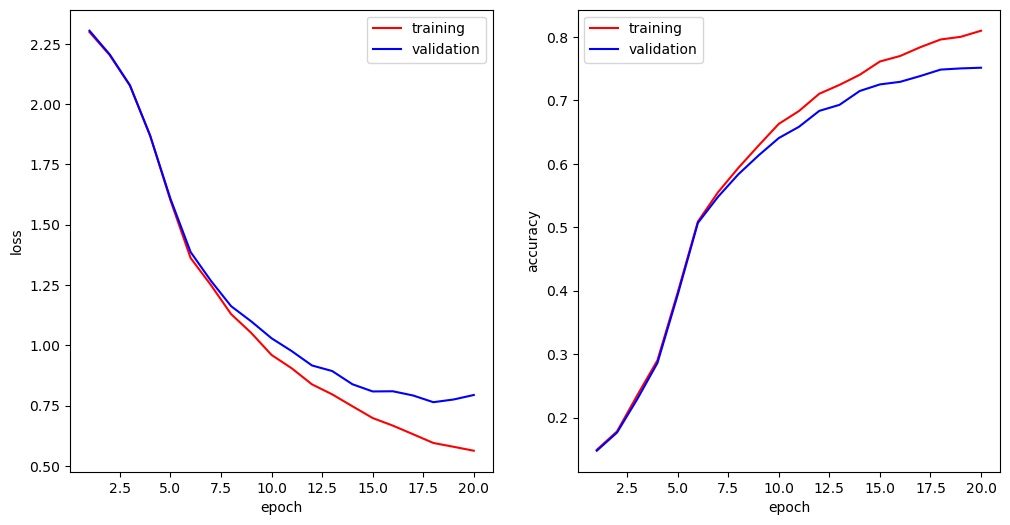

Fold #2
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.9319, Accuracy = 0.2979
client 2 : Loss = 1.8628, Accuracy = 0.3502
client 3 : Loss = 1.8281, Accuracy = 0.3395
client 4 : Loss = 1.7725, Accuracy = 0.3519
client 5 : Loss = 1.7096, Accuracy = 0.3725
client 6 : Loss = 1.7814, Accuracy = 0.3465
client 7 : Loss = 1.8643, Accuracy = 0.3363
client 8 : Loss = 1.8521, Accuracy = 0.3182

Server :
    - training loss = 2.3259
    - training accuracy = 0.1181
    - validation loss = 2.3320
    - validation accuracy = 0.1191
        
>>> Round 2 ...
client 1 : Loss = 1.6372, Accuracy = 0.3975
client 2 : Loss = 1.6329, Accuracy = 0.4102
client 3 : Loss = 1.7015, Accuracy = 0.3652
client 4 : Loss = 1.8127, Accuracy = 0.3317
client 5 : Loss = 1.7046, Accuracy = 0.3711
client 6 : Loss = 1.6913, Accuracy = 0.3678
clie

client 6 : Loss = 0.5249, Accuracy = 0.8143
client 7 : Loss = 0.5321, Accuracy = 0.8081
client 8 : Loss = 0.5303, Accuracy = 0.8129

Server :
    - training loss = 0.6275
    - training accuracy = 0.7809
    - validation loss = 0.7981
    - validation accuracy = 0.7394
        
>>> Round 17 ...
client 1 : Loss = 0.5216, Accuracy = 0.8107
client 2 : Loss = 0.4994, Accuracy = 0.8093
client 3 : Loss = 0.4721, Accuracy = 0.8256
client 4 : Loss = 0.4748, Accuracy = 0.8353
client 5 : Loss = 0.4644, Accuracy = 0.8376
client 6 : Loss = 0.5428, Accuracy = 0.8191
client 7 : Loss = 0.5103, Accuracy = 0.8171
client 8 : Loss = 0.5313, Accuracy = 0.8102

Server :
    - training loss = 0.6001
    - training accuracy = 0.7910
    - validation loss = 0.7886
    - validation accuracy = 0.7449
        
>>> Round 18 ...
client 1 : Loss = 0.5482, Accuracy = 0.8061
client 2 : Loss = 0.4606, Accuracy = 0.8354
client 3 : Loss = 0.4749, Accuracy = 0.8313
client 4 : Loss = 0.4606, Accuracy = 0.8462
client 5 : L

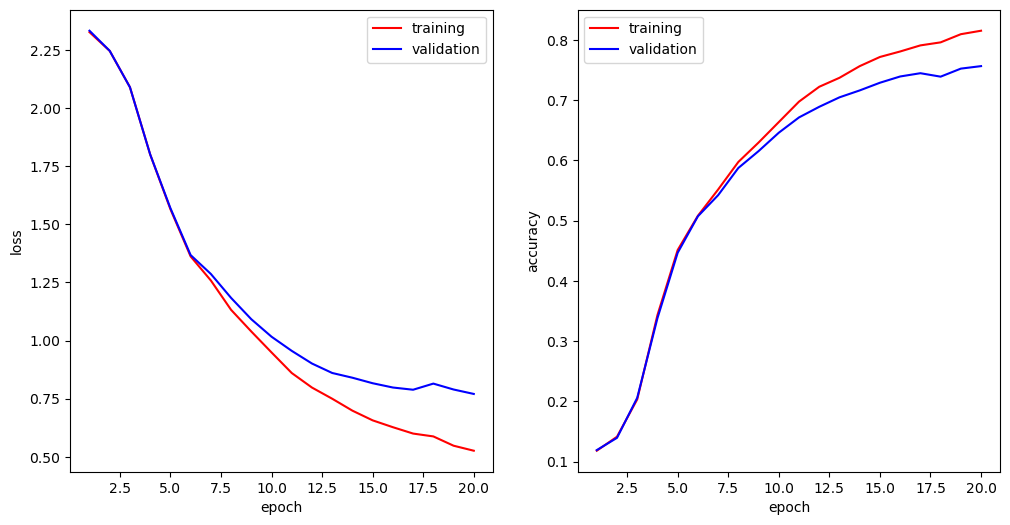

Fold #3
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.7995, Accuracy = 0.3292
client 2 : Loss = 1.8570, Accuracy = 0.3262
client 3 : Loss = 1.8130, Accuracy = 0.3499
client 4 : Loss = 1.8973, Accuracy = 0.3186
client 5 : Loss = 1.7998, Accuracy = 0.3570
client 6 : Loss = 1.6903, Accuracy = 0.3703
client 7 : Loss = 1.8944, Accuracy = 0.3291
client 8 : Loss = 1.7485, Accuracy = 0.3556

Server :
    - training loss = 2.2746
    - training accuracy = 0.1764
    - validation loss = 2.2901
    - validation accuracy = 0.1746
        
>>> Round 2 ...
client 1 : Loss = 1.6241, Accuracy = 0.4003
client 2 : Loss = 1.6557, Accuracy = 0.3787
client 3 : Loss = 1.6759, Accuracy = 0.3752
client 4 : Loss = 1.6527, Accuracy = 0.3902
client 5 : Loss = 1.6272, Accuracy = 0.3960
client 6 : Loss = 1.6284, Accuracy = 0.3932
clie

client 6 : Loss = 0.5652, Accuracy = 0.8002
client 7 : Loss = 0.5457, Accuracy = 0.8086
client 8 : Loss = 0.5551, Accuracy = 0.7950

Server :
    - training loss = 0.6450
    - training accuracy = 0.7741
    - validation loss = 0.7673
    - validation accuracy = 0.7405
        
>>> Round 17 ...
client 1 : Loss = 0.5433, Accuracy = 0.8116
client 2 : Loss = 0.4548, Accuracy = 0.8371
client 3 : Loss = 0.5220, Accuracy = 0.8053
client 4 : Loss = 0.5794, Accuracy = 0.8008
client 5 : Loss = 0.5091, Accuracy = 0.8076
client 6 : Loss = 0.4628, Accuracy = 0.8281
client 7 : Loss = 0.4388, Accuracy = 0.8375
client 8 : Loss = 0.5178, Accuracy = 0.8132

Server :
    - training loss = 0.6162
    - training accuracy = 0.7861
    - validation loss = 0.7668
    - validation accuracy = 0.7490
        
>>> Round 18 ...
client 1 : Loss = 0.5550, Accuracy = 0.8069
client 2 : Loss = 0.4501, Accuracy = 0.8414
client 3 : Loss = 0.5226, Accuracy = 0.8040
client 4 : Loss = 0.5474, Accuracy = 0.8070
client 5 : L

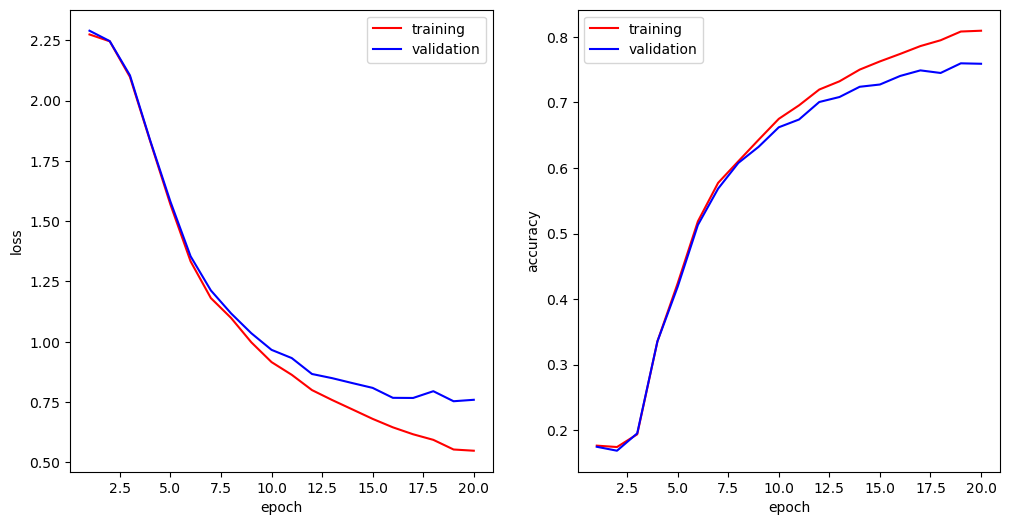

Fold #4
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.7571, Accuracy = 0.3549
client 2 : Loss = 1.8659, Accuracy = 0.3381
client 3 : Loss = 1.7556, Accuracy = 0.3605
client 4 : Loss = 1.8037, Accuracy = 0.3398
client 5 : Loss = 1.7875, Accuracy = 0.3489
client 6 : Loss = 1.7836, Accuracy = 0.3571
client 7 : Loss = 1.8588, Accuracy = 0.3178
client 8 : Loss = 1.8398, Accuracy = 0.3268

Server :
    - training loss = 2.2999
    - training accuracy = 0.1278
    - validation loss = 2.2983
    - validation accuracy = 0.1290
        
>>> Round 2 ...
client 1 : Loss = 1.6932, Accuracy = 0.3852
client 2 : Loss = 1.6667, Accuracy = 0.3719
client 3 : Loss = 1.6686, Accuracy = 0.3742
client 4 : Loss = 1.6777, Accuracy = 0.3723
client 5 : Loss = 1.6334, Accuracy = 0.3938
client 6 : Loss = 1.6981, Accuracy = 0.3771
clie

client 6 : Loss = 0.5815, Accuracy = 0.7966
client 7 : Loss = 0.4962, Accuracy = 0.8207
client 8 : Loss = 0.5236, Accuracy = 0.8015

Server :
    - training loss = 0.6681
    - training accuracy = 0.7705
    - validation loss = 0.8425
    - validation accuracy = 0.7277
        
>>> Round 17 ...
client 1 : Loss = 0.5363, Accuracy = 0.8049
client 2 : Loss = 0.5434, Accuracy = 0.8105
client 3 : Loss = 0.5330, Accuracy = 0.8102
client 4 : Loss = 0.5161, Accuracy = 0.8158
client 5 : Loss = 0.4677, Accuracy = 0.8288
client 6 : Loss = 0.5494, Accuracy = 0.8045
client 7 : Loss = 0.6007, Accuracy = 0.7949
client 8 : Loss = 0.4813, Accuracy = 0.8228

Server :
    - training loss = 0.6315
    - training accuracy = 0.7805
    - validation loss = 0.8150
    - validation accuracy = 0.7296
        
>>> Round 18 ...
client 1 : Loss = 0.5210, Accuracy = 0.8061
client 2 : Loss = 0.5053, Accuracy = 0.8236
client 3 : Loss = 0.5039, Accuracy = 0.8191
client 4 : Loss = 0.5439, Accuracy = 0.7998
client 5 : L

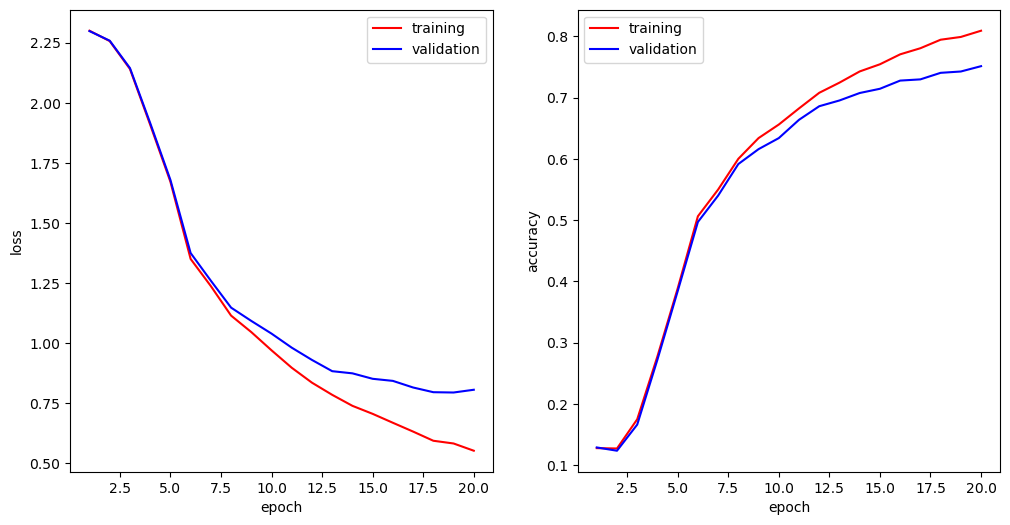

Fold #0
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.3000, Accuracy = 0.5491
client 2 : Loss = 1.1462, Accuracy = 0.5998
client 3 : Loss = 1.2122, Accuracy = 0.5657
client 4 : Loss = 1.2322, Accuracy = 0.5639
client 5 : Loss = 1.2536, Accuracy = 0.5553
client 6 : Loss = 1.2986, Accuracy = 0.5316
client 7 : Loss = 1.2735, Accuracy = 0.5490
client 8 : Loss = 1.1407, Accuracy = 0.5900

Server :
    - training loss = 1.5351
    - training accuracy = 0.4624
    - validation loss = 1.5618
    - validation accuracy = 0.4492
        
>>> Round 2 ...
client 1 : Loss = 0.9654, Accuracy = 0.6590
client 2 : Loss = 0.9240, Accuracy = 0.6750
client 3 : Loss = 1.0878, Accuracy = 0.5991
client 4 : Loss = 0.9314, Accuracy = 0.6645
client 5 : Loss = 1.0011, Accuracy = 0.6389
client 6 : Loss = 1.0213, Accuracy = 0.6245
clie

client 6 : Loss = 0.1095, Accuracy = 0.9657
client 7 : Loss = 0.0595, Accuracy = 0.9904
client 8 : Loss = 0.0791, Accuracy = 0.9799

Server :
    - training loss = 0.2158
    - training accuracy = 0.9244
    - validation loss = 0.6937
    - validation accuracy = 0.8008
        
>>> Round 17 ...
client 1 : Loss = 0.0698, Accuracy = 0.9835
client 2 : Loss = 0.0599, Accuracy = 0.9889
client 3 : Loss = 0.0592, Accuracy = 0.9894
client 4 : Loss = 0.0614, Accuracy = 0.9895
client 5 : Loss = 0.0654, Accuracy = 0.9871
client 6 : Loss = 0.0477, Accuracy = 0.9902
client 7 : Loss = 0.0638, Accuracy = 0.9851
client 8 : Loss = 0.0788, Accuracy = 0.9822

Server :
    - training loss = 0.1984
    - training accuracy = 0.9313
    - validation loss = 0.7010
    - validation accuracy = 0.7977
        
>>> Round 18 ...
client 1 : Loss = 0.0629, Accuracy = 0.9848
client 2 : Loss = 0.0722, Accuracy = 0.9850
client 3 : Loss = 0.0587, Accuracy = 0.9835
client 4 : Loss = 0.0505, Accuracy = 0.9887
client 5 : L

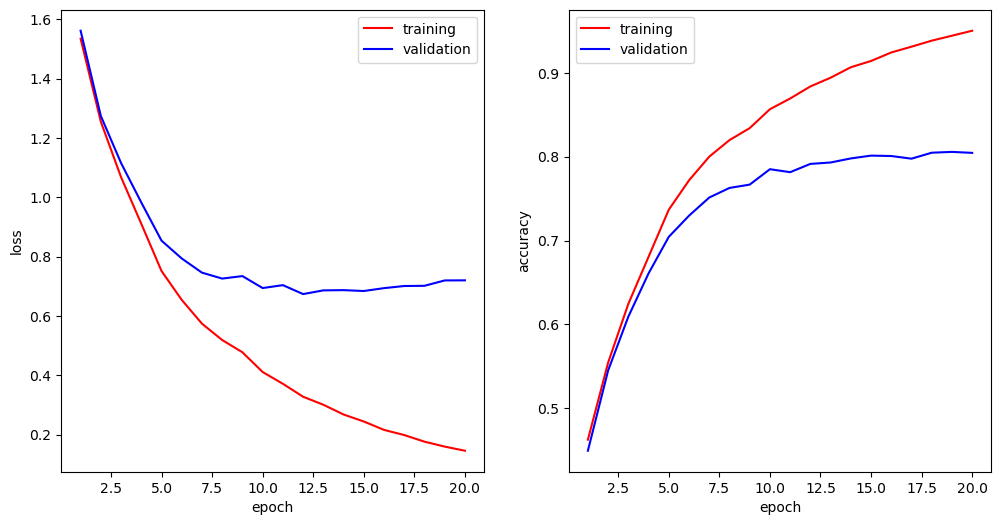

Fold #1
client 1 : 5002 samples
client 2 : 4996 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4996 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.1560, Accuracy = 0.5982
client 2 : Loss = 1.3717, Accuracy = 0.5416
client 3 : Loss = 1.1856, Accuracy = 0.5888
client 4 : Loss = 1.1800, Accuracy = 0.5854
client 5 : Loss = 1.1804, Accuracy = 0.5804
client 6 : Loss = 1.1434, Accuracy = 0.5857
client 7 : Loss = 1.3148, Accuracy = 0.5383
client 8 : Loss = 1.1605, Accuracy = 0.5910

Server :
    - training loss = 1.5192
    - training accuracy = 0.4792
    - validation loss = 1.5414
    - validation accuracy = 0.4721
        
>>> Round 2 ...
client 1 : Loss = 0.9493, Accuracy = 0.6652
client 2 : Loss = 1.0001, Accuracy = 0.6506
client 3 : Loss = 1.0416, Accuracy = 0.6331
client 4 : Loss = 1.0598, Accuracy = 0.6279
client 5 : Loss = 1.0278, Accuracy = 0.6292
client 6 : Loss = 0.9921, Accuracy = 0.6465
clie

client 6 : Loss = 0.0713, Accuracy = 0.9849
client 7 : Loss = 0.1196, Accuracy = 0.9705
client 8 : Loss = 0.0640, Accuracy = 0.9871

Server :
    - training loss = 0.2289
    - training accuracy = 0.9198
    - validation loss = 0.6899
    - validation accuracy = 0.7999
        
>>> Round 17 ...
client 1 : Loss = 0.0622, Accuracy = 0.9856
client 2 : Loss = 0.0963, Accuracy = 0.9738
client 3 : Loss = 0.0416, Accuracy = 0.9920
client 4 : Loss = 0.0698, Accuracy = 0.9867
client 5 : Loss = 0.0546, Accuracy = 0.9912
client 6 : Loss = 0.0572, Accuracy = 0.9866
client 7 : Loss = 0.0647, Accuracy = 0.9883
client 8 : Loss = 0.0695, Accuracy = 0.9817

Server :
    - training loss = 0.2033
    - training accuracy = 0.9285
    - validation loss = 0.6928
    - validation accuracy = 0.7997
        
>>> Round 18 ...
client 1 : Loss = 0.0431, Accuracy = 0.9894
client 2 : Loss = 0.0644, Accuracy = 0.9885
client 3 : Loss = 0.0385, Accuracy = 0.9957
client 4 : Loss = 0.0731, Accuracy = 0.9805
client 5 : L

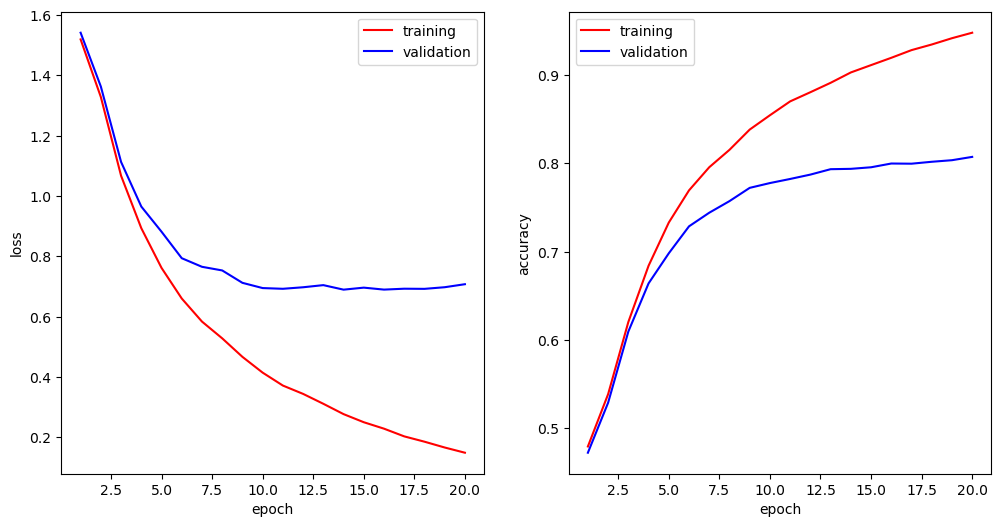

Fold #2
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.1583, Accuracy = 0.5916
client 2 : Loss = 1.1783, Accuracy = 0.5795
client 3 : Loss = 1.1769, Accuracy = 0.5834
client 4 : Loss = 1.1726, Accuracy = 0.5944
client 5 : Loss = 1.1517, Accuracy = 0.5845
client 6 : Loss = 1.2520, Accuracy = 0.5523
client 7 : Loss = 1.3571, Accuracy = 0.5299
client 8 : Loss = 1.2017, Accuracy = 0.5713

Server :
    - training loss = 1.6200
    - training accuracy = 0.4360
    - validation loss = 1.6546
    - validation accuracy = 0.4243
        
>>> Round 2 ...
client 1 : Loss = 0.9424, Accuracy = 0.6664
client 2 : Loss = 1.0332, Accuracy = 0.6359
client 3 : Loss = 1.0075, Accuracy = 0.6398
client 4 : Loss = 0.9863, Accuracy = 0.6552
client 5 : Loss = 0.9663, Accuracy = 0.6478
client 6 : Loss = 0.9444, Accuracy = 0.6693
clie

client 6 : Loss = 0.0546, Accuracy = 0.9918
client 7 : Loss = 0.0592, Accuracy = 0.9860
client 8 : Loss = 0.0633, Accuracy = 0.9881

Server :
    - training loss = 0.2192
    - training accuracy = 0.9229
    - validation loss = 0.7006
    - validation accuracy = 0.7969
        
>>> Round 17 ...
client 1 : Loss = 0.0713, Accuracy = 0.9871
client 2 : Loss = 0.0600, Accuracy = 0.9885
client 3 : Loss = 0.0843, Accuracy = 0.9773
client 4 : Loss = 0.0531, Accuracy = 0.9887
client 5 : Loss = 0.0351, Accuracy = 0.9957
client 6 : Loss = 0.0551, Accuracy = 0.9912
client 7 : Loss = 0.0676, Accuracy = 0.9840
client 8 : Loss = 0.0562, Accuracy = 0.9863

Server :
    - training loss = 0.1933
    - training accuracy = 0.9329
    - validation loss = 0.6808
    - validation accuracy = 0.8069
        
>>> Round 18 ...
client 1 : Loss = 0.0384, Accuracy = 0.9955
client 2 : Loss = 0.0483, Accuracy = 0.9926
client 3 : Loss = 0.0597, Accuracy = 0.9842
client 4 : Loss = 0.0632, Accuracy = 0.9859
client 5 : L

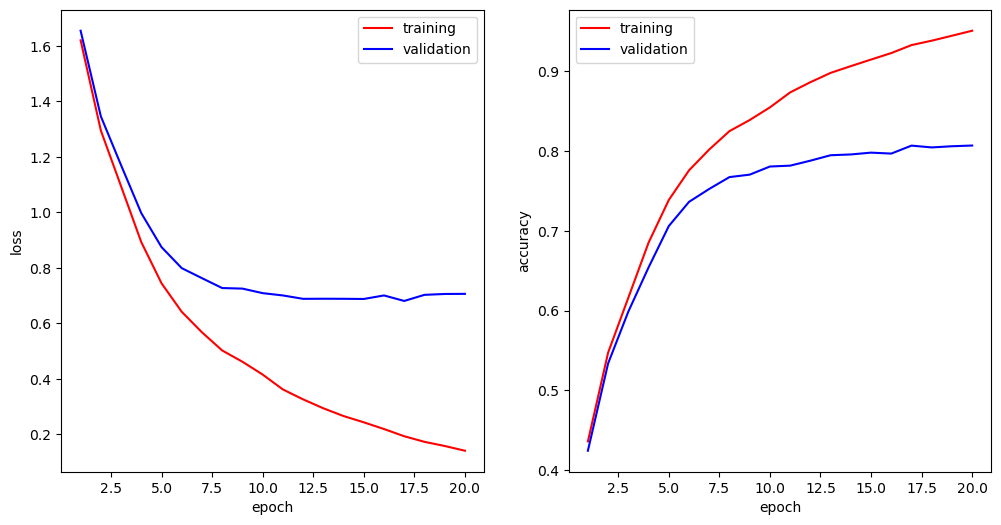

Fold #3
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.3845, Accuracy = 0.5192
client 2 : Loss = 1.2600, Accuracy = 0.5500
client 3 : Loss = 1.3012, Accuracy = 0.5441
client 4 : Loss = 1.2794, Accuracy = 0.5557
client 5 : Loss = 1.3185, Accuracy = 0.5385
client 6 : Loss = 1.2194, Accuracy = 0.5648
client 7 : Loss = 1.2734, Accuracy = 0.5420
client 8 : Loss = 1.3363, Accuracy = 0.5260

Server :
    - training loss = 1.6546
    - training accuracy = 0.4365
    - validation loss = 1.6690
    - validation accuracy = 0.4330
        
>>> Round 2 ...
client 1 : Loss = 1.0860, Accuracy = 0.6136
client 2 : Loss = 1.0103, Accuracy = 0.6322
client 3 : Loss = 1.2278, Accuracy = 0.5633
client 4 : Loss = 1.0835, Accuracy = 0.6088
client 5 : Loss = 1.0639, Accuracy = 0.6194
client 6 : Loss = 1.0757, Accuracy = 0.6182
clie

client 6 : Loss = 0.0608, Accuracy = 0.9873
client 7 : Loss = 0.0460, Accuracy = 0.9936
client 8 : Loss = 0.0641, Accuracy = 0.9902

Server :
    - training loss = 0.2274
    - training accuracy = 0.9218
    - validation loss = 0.6396
    - validation accuracy = 0.8112
        
>>> Round 17 ...
client 1 : Loss = 0.1050, Accuracy = 0.9778
client 2 : Loss = 0.0457, Accuracy = 0.9909
client 3 : Loss = 0.0654, Accuracy = 0.9906
client 4 : Loss = 0.0593, Accuracy = 0.9869
client 5 : Loss = 0.0526, Accuracy = 0.9896
client 6 : Loss = 0.0625, Accuracy = 0.9891
client 7 : Loss = 0.0473, Accuracy = 0.9894
client 8 : Loss = 0.0657, Accuracy = 0.9867

Server :
    - training loss = 0.2034
    - training accuracy = 0.9287
    - validation loss = 0.6380
    - validation accuracy = 0.8120
        
>>> Round 18 ...
client 1 : Loss = 0.0718, Accuracy = 0.9882
client 2 : Loss = 0.0633, Accuracy = 0.9879
client 3 : Loss = 0.0935, Accuracy = 0.9749
client 4 : Loss = 0.0671, Accuracy = 0.9838
client 5 : L

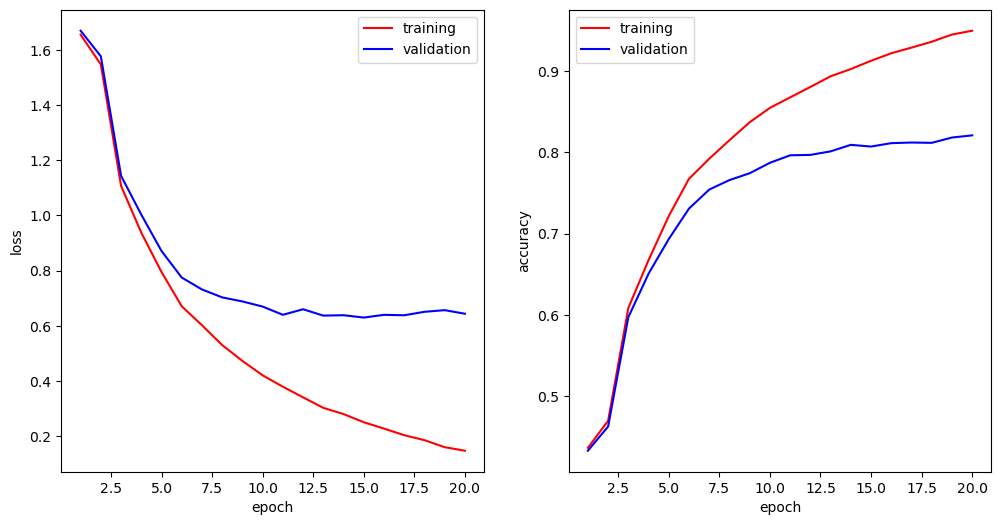

Fold #4
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.2047, Accuracy = 0.5814
client 2 : Loss = 1.3258, Accuracy = 0.5352
client 3 : Loss = 1.2049, Accuracy = 0.5799
client 4 : Loss = 1.2942, Accuracy = 0.5413
client 5 : Loss = 1.1853, Accuracy = 0.5825
client 6 : Loss = 1.2106, Accuracy = 0.5773
client 7 : Loss = 1.2023, Accuracy = 0.5785
client 8 : Loss = 1.2312, Accuracy = 0.5664

Server :
    - training loss = 1.4941
    - training accuracy = 0.4793
    - validation loss = 1.5237
    - validation accuracy = 0.4738
        
>>> Round 2 ...
client 1 : Loss = 1.0215, Accuracy = 0.6352
client 2 : Loss = 1.0016, Accuracy = 0.6426
client 3 : Loss = 1.0666, Accuracy = 0.6193
client 4 : Loss = 1.0292, Accuracy = 0.6261
client 5 : Loss = 0.9283, Accuracy = 0.6621
client 6 : Loss = 1.0398, Accuracy = 0.6351
clie

client 6 : Loss = 0.1021, Accuracy = 0.9849
client 7 : Loss = 0.0512, Accuracy = 0.9926
client 8 : Loss = 0.0708, Accuracy = 0.9830

Server :
    - training loss = 0.2198
    - training accuracy = 0.9224
    - validation loss = 0.7054
    - validation accuracy = 0.8010
        
>>> Round 17 ...
client 1 : Loss = 0.0830, Accuracy = 0.9773
client 2 : Loss = 0.0445, Accuracy = 0.9908
client 3 : Loss = 0.0599, Accuracy = 0.9896
client 4 : Loss = 0.0686, Accuracy = 0.9843
client 5 : Loss = 0.0547, Accuracy = 0.9912
client 6 : Loss = 0.0859, Accuracy = 0.9795
client 7 : Loss = 0.0565, Accuracy = 0.9896
client 8 : Loss = 0.0571, Accuracy = 0.9896

Server :
    - training loss = 0.1964
    - training accuracy = 0.9303
    - validation loss = 0.7091
    - validation accuracy = 0.8042
        
>>> Round 18 ...
client 1 : Loss = 0.0419, Accuracy = 0.9937
client 2 : Loss = 0.0661, Accuracy = 0.9826
client 3 : Loss = 0.0549, Accuracy = 0.9898
client 4 : Loss = 0.0521, Accuracy = 0.9932
client 5 : L

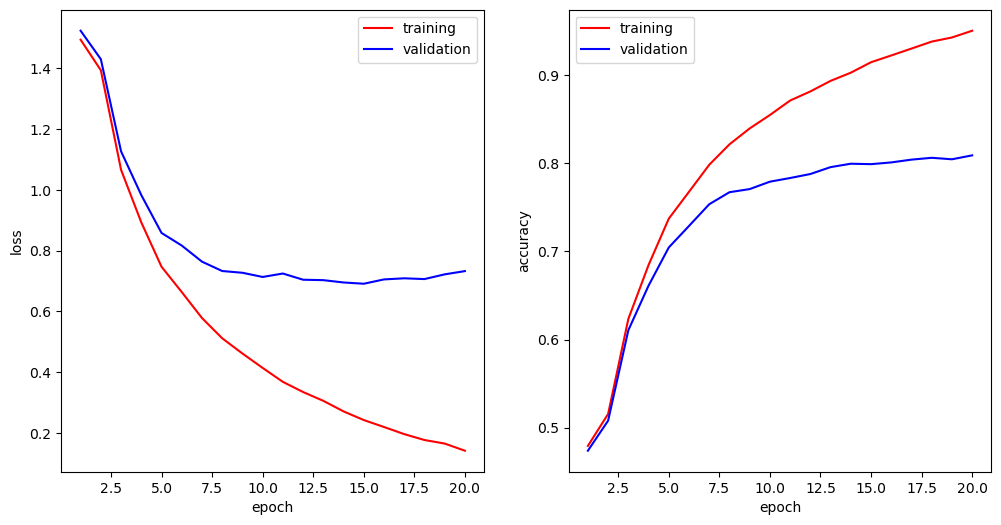

Fold #0
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.2921, Accuracy = 0.5426
client 2 : Loss = 1.2158, Accuracy = 0.5685
client 3 : Loss = 1.2441, Accuracy = 0.5641
client 4 : Loss = 1.2519, Accuracy = 0.5693
client 5 : Loss = 1.2598, Accuracy = 0.5593
client 6 : Loss = 1.2758, Accuracy = 0.5453
client 7 : Loss = 1.2611, Accuracy = 0.5551
client 8 : Loss = 1.2413, Accuracy = 0.5633

Server :
    - training loss = 1.4632
    - training accuracy = 0.4738
    - validation loss = 1.5266
    - validation accuracy = 0.4494
        
>>> Round 2 ...
client 1 : Loss = 1.0353, Accuracy = 0.6416
client 2 : Loss = 0.9950, Accuracy = 0.6498
client 3 : Loss = 1.0282, Accuracy = 0.6406
client 4 : Loss = 1.0273, Accuracy = 0.6424
client 5 : Loss = 1.0129, Accuracy = 0.6477
client 6 : Loss = 1.0487, Accuracy = 0.6361
clie

client 6 : Loss = 0.1939, Accuracy = 0.9576
client 7 : Loss = 0.1936, Accuracy = 0.9546
client 8 : Loss = 0.2084, Accuracy = 0.9455

Server :
    - training loss = 0.3181
    - training accuracy = 0.9029
    - validation loss = 0.9742
    - validation accuracy = 0.6823
        
>>> Round 17 ...
client 1 : Loss = 0.1820, Accuracy = 0.9598
client 2 : Loss = 0.1719, Accuracy = 0.9627
client 3 : Loss = 0.1699, Accuracy = 0.9623
client 4 : Loss = 0.1681, Accuracy = 0.9643
client 5 : Loss = 0.1774, Accuracy = 0.9626
client 6 : Loss = 0.1975, Accuracy = 0.9507
client 7 : Loss = 0.1625, Accuracy = 0.9666
client 8 : Loss = 0.1679, Accuracy = 0.9619

Server :
    - training loss = 0.2857
    - training accuracy = 0.9163
    - validation loss = 0.9737
    - validation accuracy = 0.6841
        
>>> Round 18 ...
client 1 : Loss = 0.1522, Accuracy = 0.9664
client 2 : Loss = 0.1366, Accuracy = 0.9752
client 3 : Loss = 0.2079, Accuracy = 0.9451
client 4 : Loss = 0.1585, Accuracy = 0.9627
client 5 : L

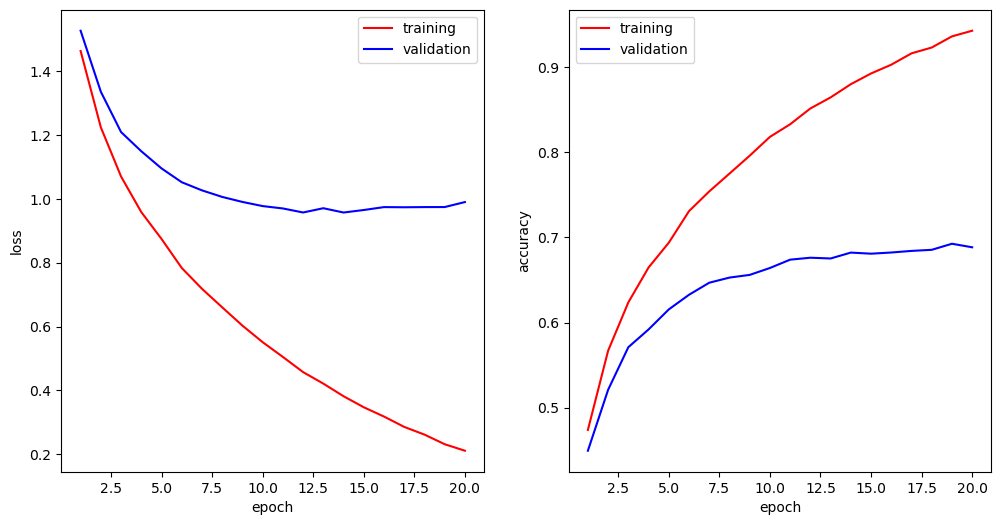

Fold #1
client 1 : 5002 samples
client 2 : 4996 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4996 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.2358, Accuracy = 0.5650
client 2 : Loss = 1.2477, Accuracy = 0.5555
client 3 : Loss = 1.1885, Accuracy = 0.5814
client 4 : Loss = 1.2154, Accuracy = 0.5691
client 5 : Loss = 1.2478, Accuracy = 0.5479
client 6 : Loss = 1.1986, Accuracy = 0.5823
client 7 : Loss = 1.2971, Accuracy = 0.5488
client 8 : Loss = 1.2146, Accuracy = 0.5804

Server :
    - training loss = 1.4442
    - training accuracy = 0.4873
    - validation loss = 1.5025
    - validation accuracy = 0.4728
        
>>> Round 2 ...
client 1 : Loss = 0.9622, Accuracy = 0.6646
client 2 : Loss = 1.0097, Accuracy = 0.6455
client 3 : Loss = 0.9604, Accuracy = 0.6740
client 4 : Loss = 0.9701, Accuracy = 0.6689
client 5 : Loss = 0.9770, Accuracy = 0.6617
client 6 : Loss = 0.9508, Accuracy = 0.6647
clie

client 6 : Loss = 0.1909, Accuracy = 0.9533
client 7 : Loss = 0.2306, Accuracy = 0.9406
client 8 : Loss = 0.1833, Accuracy = 0.9631

Server :
    - training loss = 0.3149
    - training accuracy = 0.9046
    - validation loss = 1.0033
    - validation accuracy = 0.6761
        
>>> Round 17 ...
client 1 : Loss = 0.1670, Accuracy = 0.9616
client 2 : Loss = 0.2135, Accuracy = 0.9447
client 3 : Loss = 0.1616, Accuracy = 0.9644
client 4 : Loss = 0.1596, Accuracy = 0.9658
client 5 : Loss = 0.1727, Accuracy = 0.9629
client 6 : Loss = 0.1533, Accuracy = 0.9666
client 7 : Loss = 0.2116, Accuracy = 0.9453
client 8 : Loss = 0.1589, Accuracy = 0.9704

Server :
    - training loss = 0.2897
    - training accuracy = 0.9139
    - validation loss = 1.0172
    - validation accuracy = 0.6760
        
>>> Round 18 ...
client 1 : Loss = 0.1587, Accuracy = 0.9700
client 2 : Loss = 0.1943, Accuracy = 0.9449
client 3 : Loss = 0.1439, Accuracy = 0.9670
client 4 : Loss = 0.1435, Accuracy = 0.9711
client 5 : L

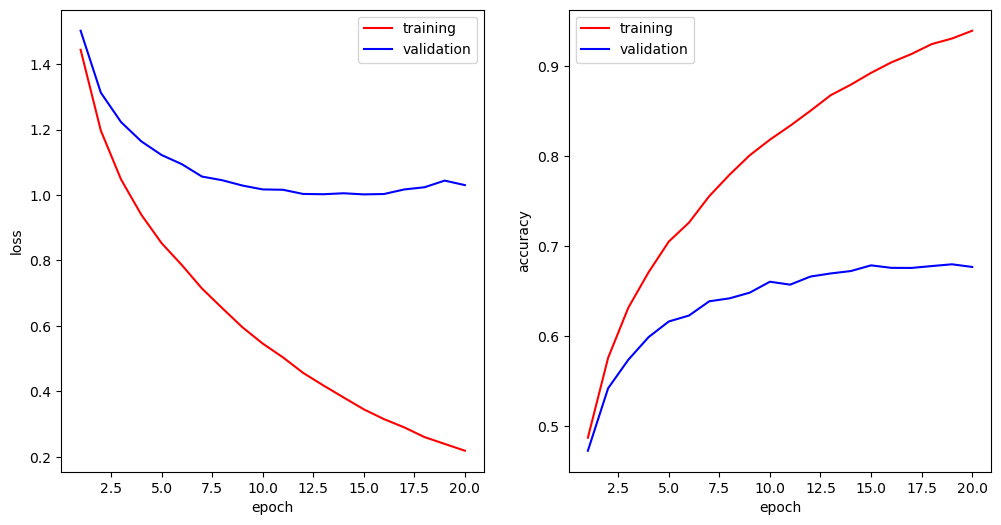

Fold #2
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.1657, Accuracy = 0.5904
client 2 : Loss = 1.1717, Accuracy = 0.5889
client 3 : Loss = 1.1999, Accuracy = 0.5752
client 4 : Loss = 1.1715, Accuracy = 0.5853
client 5 : Loss = 1.2315, Accuracy = 0.5597
client 6 : Loss = 1.1925, Accuracy = 0.5727
client 7 : Loss = 1.1810, Accuracy = 0.5849
client 8 : Loss = 1.1992, Accuracy = 0.5836

Server :
    - training loss = 1.4168
    - training accuracy = 0.4911
    - validation loss = 1.4839
    - validation accuracy = 0.4661
        
>>> Round 2 ...
client 1 : Loss = 0.9664, Accuracy = 0.6666
client 2 : Loss = 0.9499, Accuracy = 0.6685
client 3 : Loss = 0.9618, Accuracy = 0.6709
client 4 : Loss = 0.9521, Accuracy = 0.6621
client 5 : Loss = 0.9796, Accuracy = 0.6533
client 6 : Loss = 0.9805, Accuracy = 0.6564
clie

client 6 : Loss = 0.1684, Accuracy = 0.9631
client 7 : Loss = 0.1993, Accuracy = 0.9511
client 8 : Loss = 0.1802, Accuracy = 0.9566

Server :
    - training loss = 0.3067
    - training accuracy = 0.9079
    - validation loss = 1.0090
    - validation accuracy = 0.6724
        
>>> Round 17 ...
client 1 : Loss = 0.1831, Accuracy = 0.9627
client 2 : Loss = 0.1736, Accuracy = 0.9585
client 3 : Loss = 0.1545, Accuracy = 0.9654
client 4 : Loss = 0.1764, Accuracy = 0.9620
client 5 : Loss = 0.1793, Accuracy = 0.9593
client 6 : Loss = 0.1388, Accuracy = 0.9742
client 7 : Loss = 0.1683, Accuracy = 0.9598
client 8 : Loss = 0.1808, Accuracy = 0.9607

Server :
    - training loss = 0.2801
    - training accuracy = 0.9174
    - validation loss = 1.0176
    - validation accuracy = 0.6771
        
>>> Round 18 ...
client 1 : Loss = 0.1383, Accuracy = 0.9746
client 2 : Loss = 0.1536, Accuracy = 0.9630
client 3 : Loss = 0.1342, Accuracy = 0.9766
client 4 : Loss = 0.1376, Accuracy = 0.9717
client 5 : L

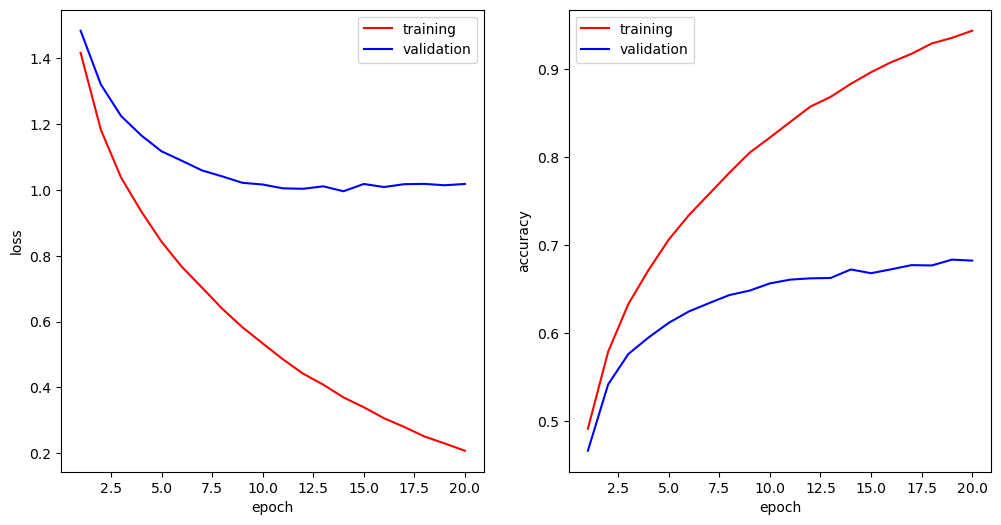

Fold #3
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.2119, Accuracy = 0.5686
client 2 : Loss = 1.2070, Accuracy = 0.5777
client 3 : Loss = 1.2502, Accuracy = 0.5603
client 4 : Loss = 1.2179, Accuracy = 0.5697
client 5 : Loss = 1.2451, Accuracy = 0.5687
client 6 : Loss = 1.2244, Accuracy = 0.5770
client 7 : Loss = 1.1950, Accuracy = 0.5877
client 8 : Loss = 1.2636, Accuracy = 0.5566

Server :
    - training loss = 1.4303
    - training accuracy = 0.4913
    - validation loss = 1.4989
    - validation accuracy = 0.4689
        
>>> Round 2 ...
client 1 : Loss = 0.9697, Accuracy = 0.6637
client 2 : Loss = 0.9442, Accuracy = 0.6815
client 3 : Loss = 0.9817, Accuracy = 0.6578
client 4 : Loss = 0.9425, Accuracy = 0.6742
client 5 : Loss = 0.9607, Accuracy = 0.6698
client 6 : Loss = 0.9402, Accuracy = 0.6715
clie

client 6 : Loss = 0.1948, Accuracy = 0.9510
client 7 : Loss = 0.1730, Accuracy = 0.9621
client 8 : Loss = 0.1960, Accuracy = 0.9526

Server :
    - training loss = 0.3061
    - training accuracy = 0.9083
    - validation loss = 0.9546
    - validation accuracy = 0.6873
        
>>> Round 17 ...
client 1 : Loss = 0.1749, Accuracy = 0.9560
client 2 : Loss = 0.1673, Accuracy = 0.9607
client 3 : Loss = 0.2041, Accuracy = 0.9481
client 4 : Loss = 0.1501, Accuracy = 0.9732
client 5 : Loss = 0.1449, Accuracy = 0.9729
client 6 : Loss = 0.1473, Accuracy = 0.9695
client 7 : Loss = 0.1641, Accuracy = 0.9601
client 8 : Loss = 0.1727, Accuracy = 0.9622

Server :
    - training loss = 0.2746
    - training accuracy = 0.9190
    - validation loss = 0.9554
    - validation accuracy = 0.6902
        
>>> Round 18 ...
client 1 : Loss = 0.1624, Accuracy = 0.9630
client 2 : Loss = 0.1244, Accuracy = 0.9797
client 3 : Loss = 0.1587, Accuracy = 0.9646
client 4 : Loss = 0.1343, Accuracy = 0.9748
client 5 : L

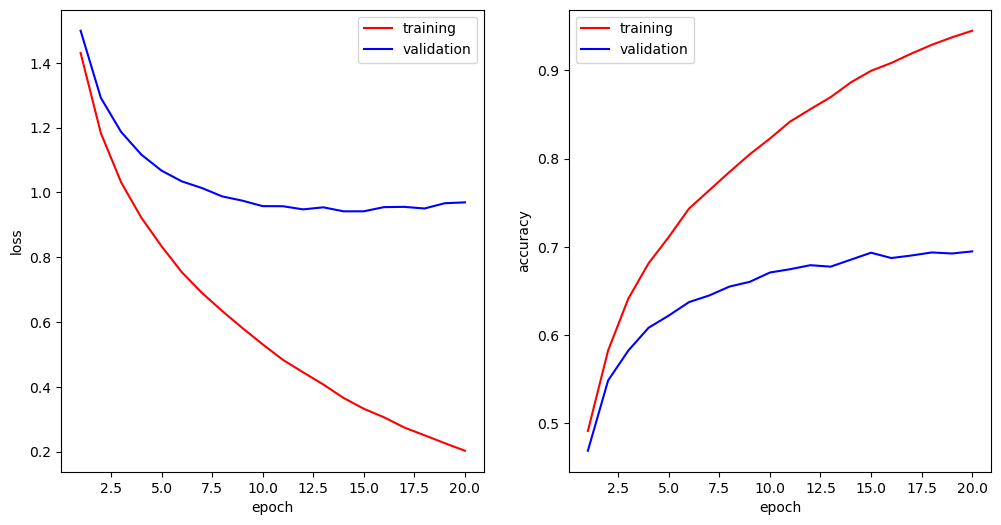

Fold #4
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.2267, Accuracy = 0.5617
client 2 : Loss = 1.2483, Accuracy = 0.5615
client 3 : Loss = 1.1963, Accuracy = 0.5742
client 4 : Loss = 1.2614, Accuracy = 0.5550
client 5 : Loss = 1.2395, Accuracy = 0.5618
client 6 : Loss = 1.2496, Accuracy = 0.5590
client 7 : Loss = 1.2797, Accuracy = 0.5477
client 8 : Loss = 1.2645, Accuracy = 0.5558

Server :
    - training loss = 1.4469
    - training accuracy = 0.4835
    - validation loss = 1.5295
    - validation accuracy = 0.4554
        
>>> Round 2 ...
client 1 : Loss = 0.9713, Accuracy = 0.6619
client 2 : Loss = 1.0039, Accuracy = 0.6449
client 3 : Loss = 0.9563, Accuracy = 0.6639
client 4 : Loss = 1.0287, Accuracy = 0.6354
client 5 : Loss = 0.9507, Accuracy = 0.6778
client 6 : Loss = 1.0499, Accuracy = 0.6333
clie

client 6 : Loss = 0.2120, Accuracy = 0.9501
client 7 : Loss = 0.2069, Accuracy = 0.9500
client 8 : Loss = 0.1991, Accuracy = 0.9545

Server :
    - training loss = 0.3189
    - training accuracy = 0.9029
    - validation loss = 0.9895
    - validation accuracy = 0.6745
        
>>> Round 17 ...
client 1 : Loss = 0.1597, Accuracy = 0.9631
client 2 : Loss = 0.1720, Accuracy = 0.9615
client 3 : Loss = 0.1819, Accuracy = 0.9553
client 4 : Loss = 0.1679, Accuracy = 0.9678
client 5 : Loss = 0.1693, Accuracy = 0.9612
client 6 : Loss = 0.1749, Accuracy = 0.9593
client 7 : Loss = 0.1809, Accuracy = 0.9602
client 8 : Loss = 0.1796, Accuracy = 0.9578

Server :
    - training loss = 0.2898
    - training accuracy = 0.9146
    - validation loss = 0.9943
    - validation accuracy = 0.6753
        
>>> Round 18 ...
client 1 : Loss = 0.1439, Accuracy = 0.9752
client 2 : Loss = 0.1705, Accuracy = 0.9633
client 3 : Loss = 0.1682, Accuracy = 0.9582
client 4 : Loss = 0.1532, Accuracy = 0.9669
client 5 : L

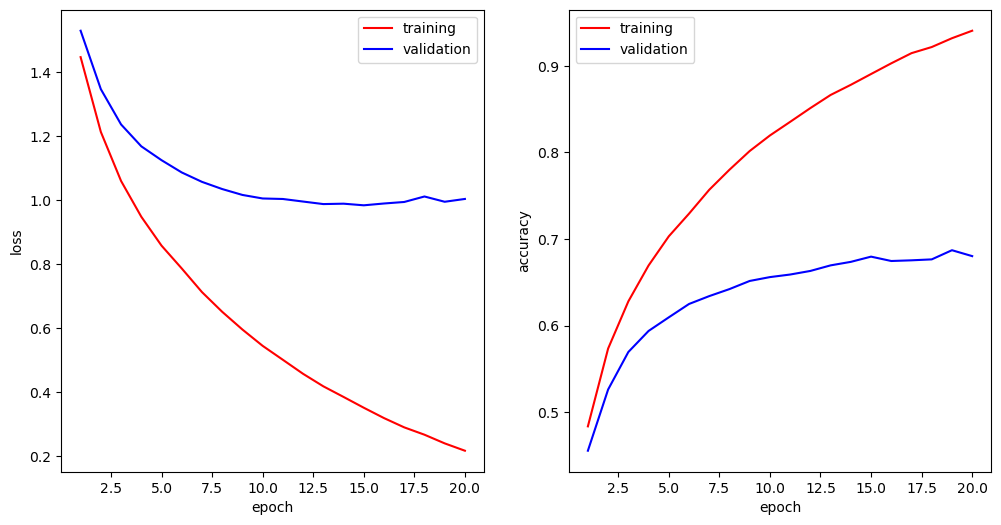

Fold #0
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 2.2448, Accuracy = 0.2486
client 2 : Loss = 2.2091, Accuracy = 0.2693
client 3 : Loss = 2.2597, Accuracy = 0.2440
client 4 : Loss = 2.2489, Accuracy = 0.2486
client 5 : Loss = 2.2617, Accuracy = 0.2558
client 6 : Loss = 2.2326, Accuracy = 0.2564
client 7 : Loss = 2.2220, Accuracy = 0.2587
client 8 : Loss = 2.2339, Accuracy = 0.2479

Server :
    - training loss = 1.9827
    - training accuracy = 0.2956
    - validation loss = 1.9939
    - validation accuracy = 0.2912
        
>>> Round 2 ...
client 1 : Loss = 2.0218, Accuracy = 0.3083
client 2 : Loss = 1.9855, Accuracy = 0.3190
client 3 : Loss = 2.0133, Accuracy = 0.3216
client 4 : Loss = 1.9978, Accuracy = 0.3168
client 5 : Loss = 2.0256, Accuracy = 0.2987
client 6 : Loss = 2.0073, Accuracy = 0.3154
clie

client 6 : Loss = 1.2974, Accuracy = 0.5412
client 7 : Loss = 1.2811, Accuracy = 0.5459
client 8 : Loss = 1.2982, Accuracy = 0.5361

Server :
    - training loss = 1.1438
    - training accuracy = 0.6015
    - validation loss = 1.2897
    - validation accuracy = 0.5391
        
>>> Round 17 ...
client 1 : Loss = 1.2524, Accuracy = 0.5666
client 2 : Loss = 1.2438, Accuracy = 0.5568
client 3 : Loss = 1.2704, Accuracy = 0.5492
client 4 : Loss = 1.2468, Accuracy = 0.5508
client 5 : Loss = 1.2757, Accuracy = 0.5498
client 6 : Loss = 1.2716, Accuracy = 0.5428
client 7 : Loss = 1.2608, Accuracy = 0.5547
client 8 : Loss = 1.2697, Accuracy = 0.5520

Server :
    - training loss = 1.1211
    - training accuracy = 0.6111
    - validation loss = 1.2750
    - validation accuracy = 0.5440
        
>>> Round 18 ...
client 1 : Loss = 1.2415, Accuracy = 0.5634
client 2 : Loss = 1.2510, Accuracy = 0.5668
client 3 : Loss = 1.2442, Accuracy = 0.5600
client 4 : Loss = 1.2564, Accuracy = 0.5525
client 5 : L

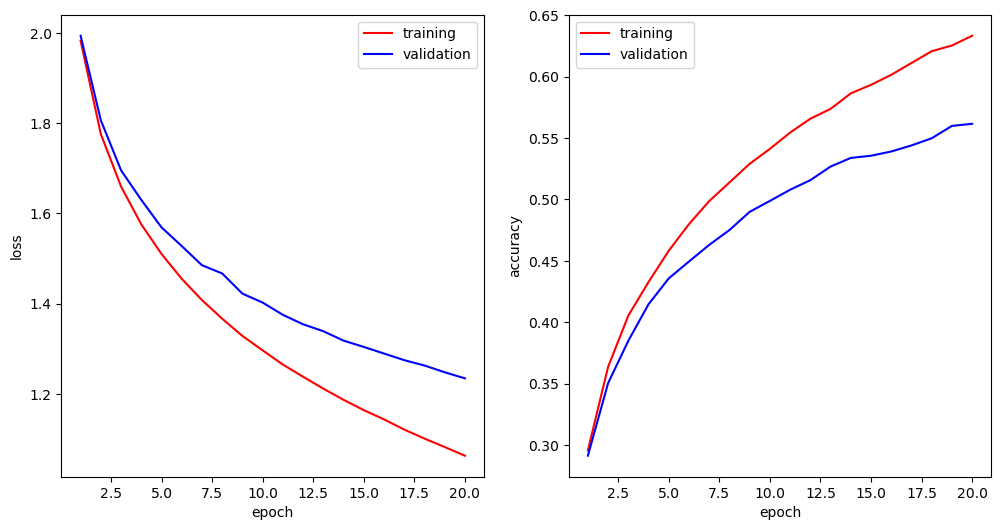

Fold #1
client 1 : 5002 samples
client 2 : 4996 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4996 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 2.2901, Accuracy = 0.2511
client 2 : Loss = 2.3438, Accuracy = 0.2301
client 3 : Loss = 2.2853, Accuracy = 0.2426
client 4 : Loss = 2.3204, Accuracy = 0.2266
client 5 : Loss = 2.3217, Accuracy = 0.2321
client 6 : Loss = 2.2593, Accuracy = 0.2441
client 7 : Loss = 2.3012, Accuracy = 0.2379
client 8 : Loss = 2.2913, Accuracy = 0.2486

Server :
    - training loss = 2.0295
    - training accuracy = 0.2746
    - validation loss = 2.0396
    - validation accuracy = 0.2651
        
>>> Round 2 ...
client 1 : Loss = 2.0162, Accuracy = 0.3155
client 2 : Loss = 2.0450, Accuracy = 0.3063
client 3 : Loss = 2.0448, Accuracy = 0.3043
client 4 : Loss = 2.0804, Accuracy = 0.2959
client 5 : Loss = 2.0548, Accuracy = 0.3076
client 6 : Loss = 2.0776, Accuracy = 0.2928
clie

client 6 : Loss = 1.2847, Accuracy = 0.5480
client 7 : Loss = 1.2782, Accuracy = 0.5488
client 8 : Loss = 1.2893, Accuracy = 0.5463

Server :
    - training loss = 1.1395
    - training accuracy = 0.6035
    - validation loss = 1.3058
    - validation accuracy = 0.5404
        
>>> Round 17 ...
client 1 : Loss = 1.2651, Accuracy = 0.5528
client 2 : Loss = 1.2727, Accuracy = 0.5564
client 3 : Loss = 1.2746, Accuracy = 0.5422
client 4 : Loss = 1.2830, Accuracy = 0.5398
client 5 : Loss = 1.2740, Accuracy = 0.5393
client 6 : Loss = 1.2603, Accuracy = 0.5515
client 7 : Loss = 1.2762, Accuracy = 0.5531
client 8 : Loss = 1.2501, Accuracy = 0.5545

Server :
    - training loss = 1.1171
    - training accuracy = 0.6110
    - validation loss = 1.2946
    - validation accuracy = 0.5424
        
>>> Round 18 ...
client 1 : Loss = 1.2536, Accuracy = 0.5625
client 2 : Loss = 1.2326, Accuracy = 0.5666
client 3 : Loss = 1.2439, Accuracy = 0.5594
client 4 : Loss = 1.2336, Accuracy = 0.5633
client 5 : L

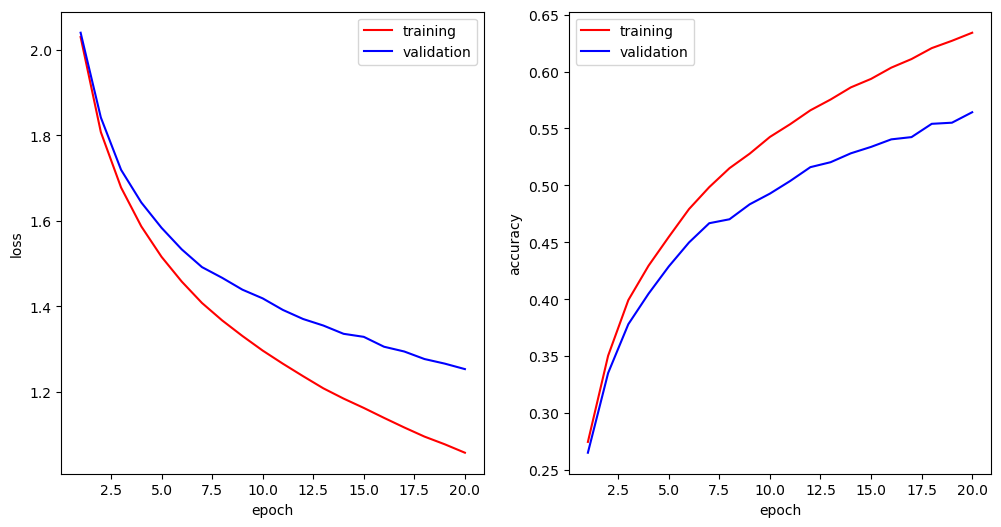

Fold #2
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 2.2424, Accuracy = 0.2432
client 2 : Loss = 2.2810, Accuracy = 0.2381
client 3 : Loss = 2.2383, Accuracy = 0.2496
client 4 : Loss = 2.2167, Accuracy = 0.2547
client 5 : Loss = 2.2304, Accuracy = 0.2513
client 6 : Loss = 2.2427, Accuracy = 0.2500
client 7 : Loss = 2.2857, Accuracy = 0.2442
client 8 : Loss = 2.2500, Accuracy = 0.2473

Server :
    - training loss = 2.0081
    - training accuracy = 0.2798
    - validation loss = 2.0171
    - validation accuracy = 0.2730
        
>>> Round 2 ...
client 1 : Loss = 2.0358, Accuracy = 0.3018
client 2 : Loss = 2.0402, Accuracy = 0.3025
client 3 : Loss = 2.0203, Accuracy = 0.3047
client 4 : Loss = 2.0178, Accuracy = 0.3181
client 5 : Loss = 2.0571, Accuracy = 0.2885
client 6 : Loss = 2.0152, Accuracy = 0.3199
clie

client 6 : Loss = 1.2660, Accuracy = 0.5492
client 7 : Loss = 1.2918, Accuracy = 0.5489
client 8 : Loss = 1.2589, Accuracy = 0.5641

Server :
    - training loss = 1.1302
    - training accuracy = 0.6066
    - validation loss = 1.3053
    - validation accuracy = 0.5422
        
>>> Round 17 ...
client 1 : Loss = 1.2388, Accuracy = 0.5551
client 2 : Loss = 1.2327, Accuracy = 0.5559
client 3 : Loss = 1.2434, Accuracy = 0.5557
client 4 : Loss = 1.2279, Accuracy = 0.5666
client 5 : Loss = 1.2443, Accuracy = 0.5558
client 6 : Loss = 1.2454, Accuracy = 0.5637
client 7 : Loss = 1.2462, Accuracy = 0.5665
client 8 : Loss = 1.2361, Accuracy = 0.5543

Server :
    - training loss = 1.1106
    - training accuracy = 0.6134
    - validation loss = 1.2895
    - validation accuracy = 0.5451
        
>>> Round 18 ...
client 1 : Loss = 1.2083, Accuracy = 0.5746
client 2 : Loss = 1.2088, Accuracy = 0.5722
client 3 : Loss = 1.2124, Accuracy = 0.5723
client 4 : Loss = 1.2034, Accuracy = 0.5706
client 5 : L

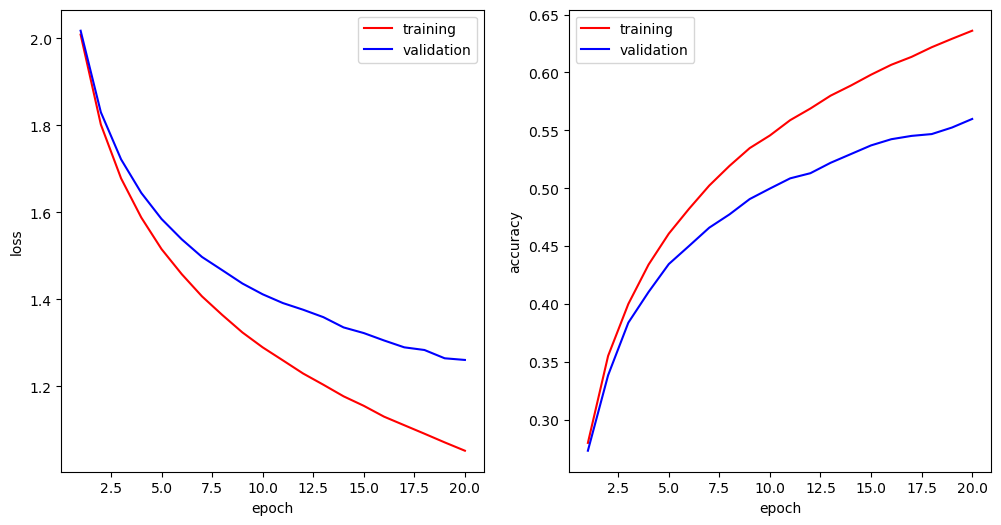

Fold #3
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 2.2857, Accuracy = 0.2323
client 2 : Loss = 2.2265, Accuracy = 0.2613
client 3 : Loss = 2.2949, Accuracy = 0.2305
client 4 : Loss = 2.2331, Accuracy = 0.2453
client 5 : Loss = 2.2415, Accuracy = 0.2331
client 6 : Loss = 2.2014, Accuracy = 0.2623
client 7 : Loss = 2.2820, Accuracy = 0.2331
client 8 : Loss = 2.2831, Accuracy = 0.2356

Server :
    - training loss = 2.0102
    - training accuracy = 0.2805
    - validation loss = 2.0422
    - validation accuracy = 0.2782
        
>>> Round 2 ...
client 1 : Loss = 2.0436, Accuracy = 0.3068
client 2 : Loss = 2.0506, Accuracy = 0.3034
client 3 : Loss = 2.0177, Accuracy = 0.3036
client 4 : Loss = 1.9957, Accuracy = 0.3129
client 5 : Loss = 2.0103, Accuracy = 0.3113
client 6 : Loss = 2.0010, Accuracy = 0.3137
clie

client 6 : Loss = 1.3042, Accuracy = 0.5395
client 7 : Loss = 1.2818, Accuracy = 0.5454
client 8 : Loss = 1.3197, Accuracy = 0.5416

Server :
    - training loss = 1.1452
    - training accuracy = 0.6022
    - validation loss = 1.2994
    - validation accuracy = 0.5390
        
>>> Round 17 ...
client 1 : Loss = 1.2467, Accuracy = 0.5602
client 2 : Loss = 1.2696, Accuracy = 0.5536
client 3 : Loss = 1.2894, Accuracy = 0.5458
client 4 : Loss = 1.2657, Accuracy = 0.5490
client 5 : Loss = 1.2612, Accuracy = 0.5568
client 6 : Loss = 1.2591, Accuracy = 0.5541
client 7 : Loss = 1.2593, Accuracy = 0.5594
client 8 : Loss = 1.2606, Accuracy = 0.5510

Server :
    - training loss = 1.1249
    - training accuracy = 0.6094
    - validation loss = 1.2915
    - validation accuracy = 0.5447
        
>>> Round 18 ...
client 1 : Loss = 1.2471, Accuracy = 0.5626
client 2 : Loss = 1.2384, Accuracy = 0.5544
client 3 : Loss = 1.2627, Accuracy = 0.5568
client 4 : Loss = 1.2040, Accuracy = 0.5787
client 5 : L

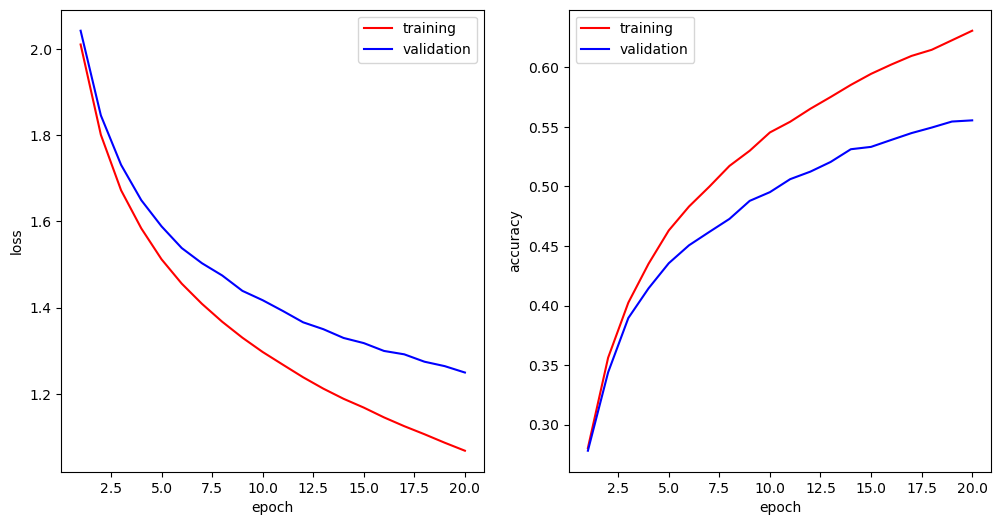

Fold #4
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 2.2835, Accuracy = 0.2371
client 2 : Loss = 2.3023, Accuracy = 0.2412
client 3 : Loss = 2.2377, Accuracy = 0.2557
client 4 : Loss = 2.2686, Accuracy = 0.2408
client 5 : Loss = 2.2499, Accuracy = 0.2460
client 6 : Loss = 2.3095, Accuracy = 0.2523
client 7 : Loss = 2.2710, Accuracy = 0.2445
client 8 : Loss = 2.2458, Accuracy = 0.2505

Server :
    - training loss = 1.9981
    - training accuracy = 0.2852
    - validation loss = 2.0231
    - validation accuracy = 0.2758
        
>>> Round 2 ...
client 1 : Loss = 2.0166, Accuracy = 0.3096
client 2 : Loss = 1.9819, Accuracy = 0.3203
client 3 : Loss = 2.0388, Accuracy = 0.3113
client 4 : Loss = 2.0444, Accuracy = 0.2991
client 5 : Loss = 2.0120, Accuracy = 0.3116
client 6 : Loss = 2.0320, Accuracy = 0.3163
clie

client 6 : Loss = 1.3500, Accuracy = 0.5186
client 7 : Loss = 1.2480, Accuracy = 0.5580
client 8 : Loss = 1.2935, Accuracy = 0.5367

Server :
    - training loss = 1.1437
    - training accuracy = 0.6020
    - validation loss = 1.3214
    - validation accuracy = 0.5312
        
>>> Round 17 ...
client 1 : Loss = 1.3127, Accuracy = 0.5332
client 2 : Loss = 1.2541, Accuracy = 0.5545
client 3 : Loss = 1.2638, Accuracy = 0.5559
client 4 : Loss = 1.2803, Accuracy = 0.5559
client 5 : Loss = 1.2737, Accuracy = 0.5437
client 6 : Loss = 1.3192, Accuracy = 0.5291
client 7 : Loss = 1.2546, Accuracy = 0.5525
client 8 : Loss = 1.2657, Accuracy = 0.5581

Server :
    - training loss = 1.1246
    - training accuracy = 0.6103
    - validation loss = 1.3090
    - validation accuracy = 0.5318
        
>>> Round 18 ...
client 1 : Loss = 1.2480, Accuracy = 0.5600
client 2 : Loss = 1.2147, Accuracy = 0.5623
client 3 : Loss = 1.2591, Accuracy = 0.5580
client 4 : Loss = 1.2529, Accuracy = 0.5631
client 5 : L

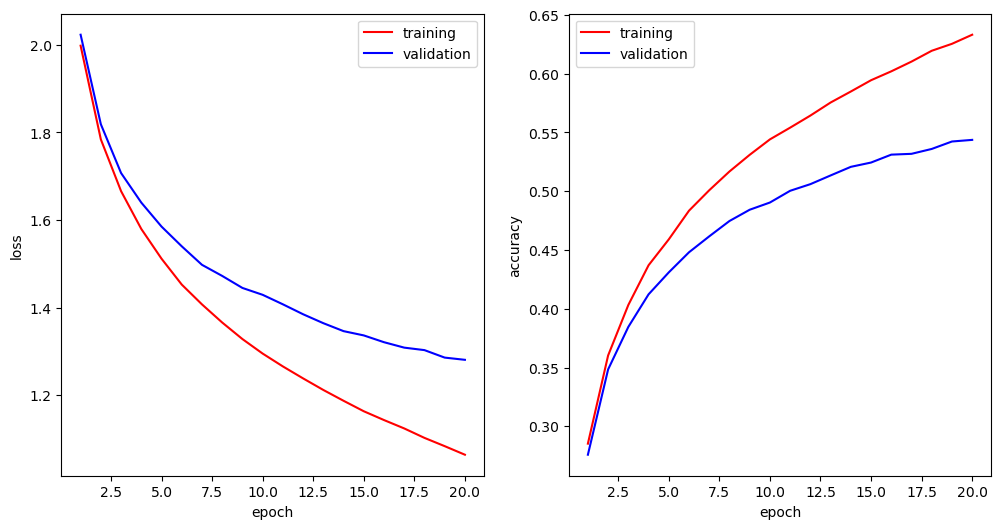

RESULTS
lr = 0.1000 : Accuracy = 0.7534810304641724
lr = 0.0100 : Accuracy = 0.8097705841064453
lr = 0.0010 : Accuracy = 0.6845529675483704
lr = 0.0001 : Accuracy = 0.5569422841072083

CPU times: user 2h 14min 29s, sys: 2.91 s, total: 2h 14min 31s
Wall time: 2h 13min 48s


In [18]:
%%time
n_splits = 5
rounds = 20
batch_size = 128
epochs = 5
lrs = [1e-1,1e-2,1e-3,1e-4]
optimizer = optim.Adagrad

results = []
for lr in lrs:
    res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr)
    results.append((lr,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for lr,res in results:
    print(f"lr = {lr:.4f} : Accuracy = {res}")
print()
